# Importation des bibliothèques 

In [1]:
!pip install matplotlib

In [2]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import time

import pandas as pd
import math
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
import mlflow
import mlflow.lightgbm
from mlflow.models import infer_signature
import mlflow.sklearn
import mlflow.pyfunc
import pickle
import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


# Chargement des données 

In [3]:
file_path = 'D:\Projet_7_modèle_scoring\data'
app_train = pd.read_csv(file_path + '\\application_train.csv')
app_test = pd.read_csv(file_path + '\\application_test.csv')
bureau_df = pd.read_csv(file_path + '\\bureau.csv')
bureau_balance_df = pd.read_csv(file_path + '\\bureau_balance.csv')
pos_cash_balance_df = pd.read_csv(file_path + '\\POS_CASH_balance.csv')
credit_card_balance_df = pd.read_csv(file_path + '\\credit_card_balance.csv')
previous_application_df = pd.read_csv(file_path + '\\previous_application.csv')
installments_payments_df = pd.read_csv(file_path + '\\installments_payments.csv')

In [4]:
df_train = app_train
df = app_train
df_test = app_test
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [5]:
#train_len = app_train.shape[0]
#train_dataset = app_train[:train_len]
# = train_dataset['SK_ID_CURR']
#train_dataset.drop(columns=['SK_ID_CURR'], axis = 1, inplace=True)


In [6]:
df_train.shape

(307511, 122)

In [7]:
df_test.shape

(48744, 121)

In [8]:
# summarize the class distribution
target = df_train['TARGET'].values
counter = Counter(target)
for k,v in counter.items():
 per = v / len(target) * 100
 print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=1, Count=24825, Percentage=8.073%
Class=0, Count=282686, Percentage=91.927%


# Exploration de données

## Distribution de la Target Column

La cible est ce que nous sommes invités à prédire : soit un 0 pour le prêt a été remboursé à temps, soit un 1 indiquant que le client a eu des difficultés de paiement. Nous pouvons d’abord examiner le nombre de prêts tombant dans chaque catégorie.

In [9]:
# summarize the class distribution
target = app_train['TARGET'].values
counter = Counter(target)
for k,v in counter.items():
 per = v / len(target) * 100
 print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))
    
app_train['TARGET'].value_counts()

Class=1, Count=24825, Percentage=8.073%
Class=0, Count=282686, Percentage=91.927%


TARGET
0    282686
1     24825
Name: count, dtype: int64

Nous remarquons que nous avons un jeu de données déséquilibrés. La classe 0 représentant les gens qui ont remboursés leur crédit sans souccis représente 92% et l'autre classe 1 représentant ceux ayant eu des difficultés est de 8%

<Axes: ylabel='Frequency'>

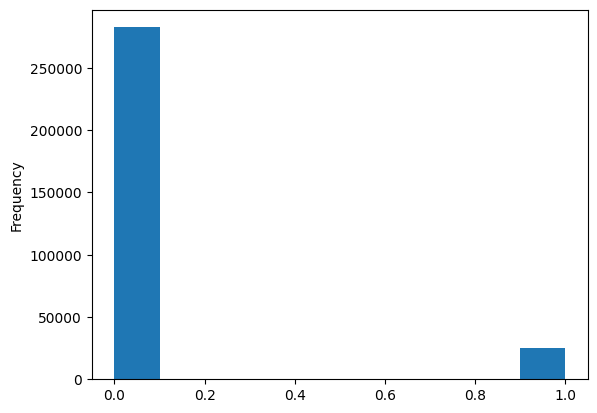

In [10]:
app_train['TARGET'].astype(int).plot.hist()

Nous constatons qu’il s’agit d’un problème de classe déséquilibrée. Il y a beaucoup plus de prêts qui ont été remboursés à temps que de prêts qui n’ont pas été remboursés. Lorsque nous aborderons des modèles d’apprentissage automatique plus sophistiqués, nous pourrons pondérer les classes en fonction de leur représentation dans les données pour refléter ce déséquilibre.

## Traitement et nettoyage du dataset

### Valeurs manquantes 

In [11]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [12]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


### Types de colonnes 

In [13]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [14]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Transformation des variables 

**Label Encoding and One-Hot Encoding**

Mettons en œuvre l'approche suivante : pour toute variable catégorielle (dtype == object) avec 2 catégories uniques, nous utiliserons l’encodage par étiquettes, et pour toute variable catégorielle avec plus de 2 catégories uniques, nous utiliserons l’encodage one-hot.

Pour l’encodage par étiquettes, nous utilisons le LabelEncoder de Scikit-Learn et pour l’encodage one-hot, la fonction pandas get_dummies(df).

In [15]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0
encoded_cols = []

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            encoded_cols.append(col)
            
print('%d columns were label encoded.' % le_count)
print('The columns that were label encoded are: ', encoded_cols)


3 columns were label encoded.
The columns that were label encoded are:  ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']


In [16]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


Il doit y avoir les mêmes caractéristiques (colonnes) dans les données d’entraînement et de test. L’encodage one-hot a créé plus de colonnes dans les données d’entraînement car il y avait des variables catégorielles avec des catégories non représentées dans les données de test. Pour supprimer les colonnes dans les données d’entraînement qui ne sont pas dans les données de test, nous devons aligner les dataframes. Tout d’abord, nous allons extraire la colonne cible des données d’entraînement (car elle n’est pas dans les données de test mais nous devons conserver cette information). Lorsque nous faisons l’alignement, nous devons nous assurer de définir axis = 1 pour aligner les dataframes en fonction des colonnes et non des lignes !

In [17]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


Les ensembles de données d’entraînement et de test ont maintenant les mêmes caractéristiques, ce qui est nécessaire pour l’apprentissage automatique. Le nombre de caractéristiques a considérablement augmenté en raison de l’encodage one-hot. À un moment donné, nous voudrons probablement essayer la réduction de la dimensionnalité (en supprimant les caractéristiques qui ne sont pas pertinentes) pour réduire la taille des ensembles de données.

### Valleurs abérantes

Un problème que nous voulons toujours surveiller lors de l’exploration de données est les anomalies dans les données. Celles-ci peuvent être dues à des nombres mal tapés, à des erreurs dans les équipements de mesure, ou elles pourraient être valides mais des mesures extrêmes.

Une façon de prendre en charge les anomalies de manière quantitative est de regarder les statistiques d’une colonne en utilisant la méthode describe. Les nombres dans la colonne DAYS_BIRTH sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une année:

In [18]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Ces âges semblent raisonnables. Il n’y a pas de valeurs aberrantes pour l’âge, ni à la hausse ni à la baisse. Et pour les jours d’emploi?

In [19]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

La variable DAYS_EMPLOYED est le nombre de jours avant la demande de crédit où la personne a commencé son emploi actuel.Nous voyons qu'il ya un problème avec les données de cette colonne. En divisant la valeur max par 365 jours on trouve que la personne travaille depuis 1000 ans!

Text(0.5, 0, 'Days Employment')

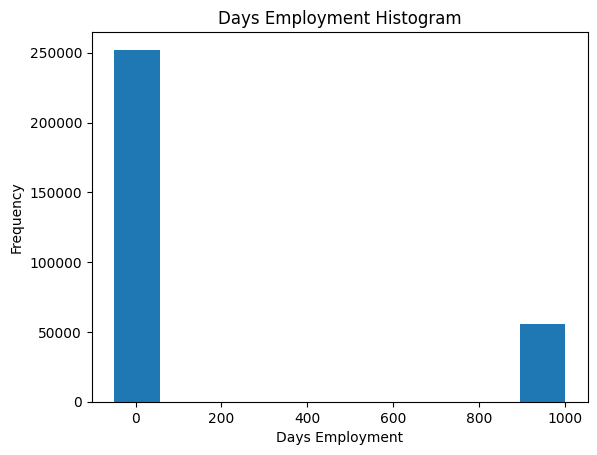

In [20]:
(app_train['DAYS_EMPLOYED'] / 365).plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

Par curiosité, sélectionnons les clients anormaux et voyons s'ils ont tendance à avoir des taux de défaut plus élevés ou plus bas que le reste des clients.

In [21]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Eh bien, c'est extrêmement intéressant! Il s'avère que les anomalies ont un taux de défaut plus faible.

La gestion des anomalies dépend de la situation exacte, sans règles établies. L'une des approches les plus sûres consiste simplement à définir les anomalies comme des valeurs manquantes, puis à les remplir (en utilisant l'imputation) avant l'apprentissage automatique. Dans ce cas, puisque toutes les anomalies ont exactement la même valeur, nous voulons les remplir avec la même valeur au cas où tous ces prêts auraient quelque chose en commun. Les valeurs anormales semblent avoir une certaine importance, nous voulons donc indiquer au modèle d'apprentissage automatique si nous avons effectivement rempli ces valeurs. Comme solution, nous remplirons les valeurs anormales avec "valeurs manquantes" (np.nan) et créerons ensuite une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.

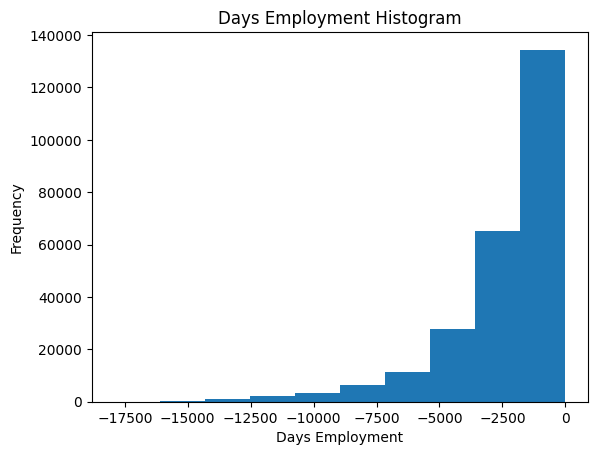

In [22]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

La distribution semble être beaucoup plus cohérente, et nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient à l'origine anormales (car nous devrons remplir les nan avec une valeur, probablement la médiane de la colonne). Les autres colonnes avec DAYS dans le dataframe semblent être à peu près ce à quoi nous nous attendons sans valeurs aberrantes évidentes.

Tout ce que nous faisons aux données d'entraînement, nous devons également le faire aux données de test. Assurons-nous de créer la nouvelle colonne et de remplir la colonne existante avec np.nan dans les données de test.

In [23]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


#### valeurs abérrantes sur le revenu 

Vérifions les valeurs abbérantes qui sont liées au revenu des debiteurs. On s'est rendu compte que certaines personnes ont 117 000 000$ et qui sont débiteurs. Ce qui est assez étrangers. Cependant après plusieurs essais nous avons considéré 2 millions comme valeurs max parce que beaucoup de gens ont un revenu supérieur à 500 000$ et autant de personnes (voir graphiques ci-dessous) ne peuvent pas être des erreurs de remplissage. Ils s'agit donc là des vrais valeurs.

Text(0.5, 0, 'revenu')

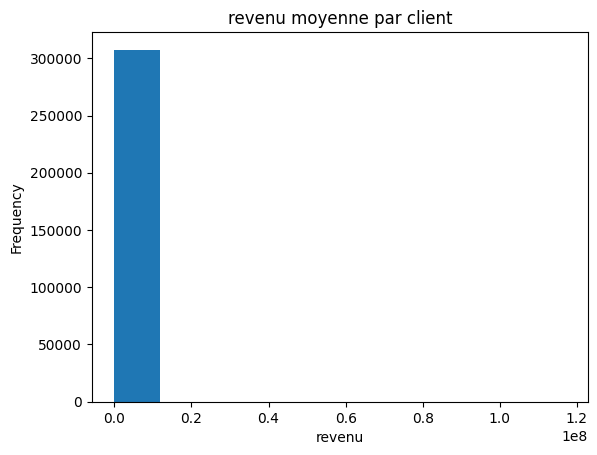

In [24]:
app_train['AMT_INCOME_TOTAL'].plot.hist(title='revenu moyenne par client')
plt.xlabel('revenu')

In [25]:
app_train['AMT_INCOME_TOTAL'].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

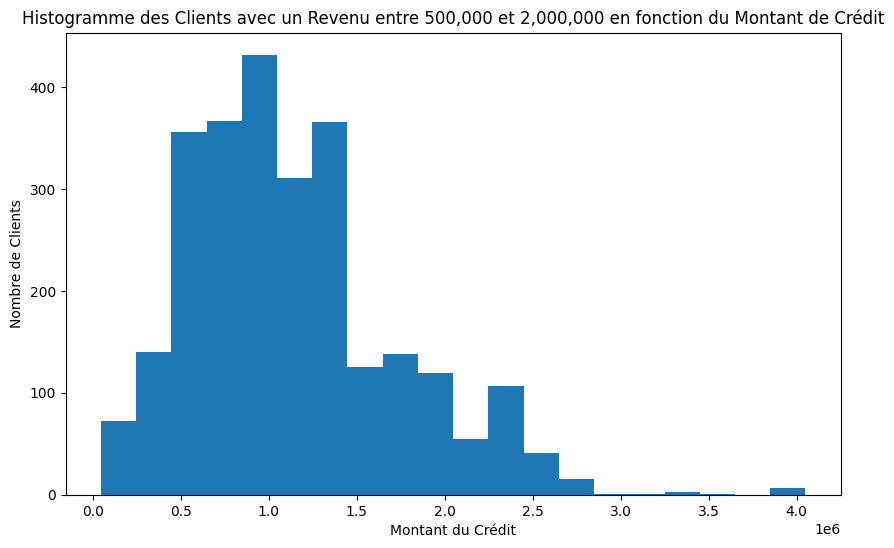

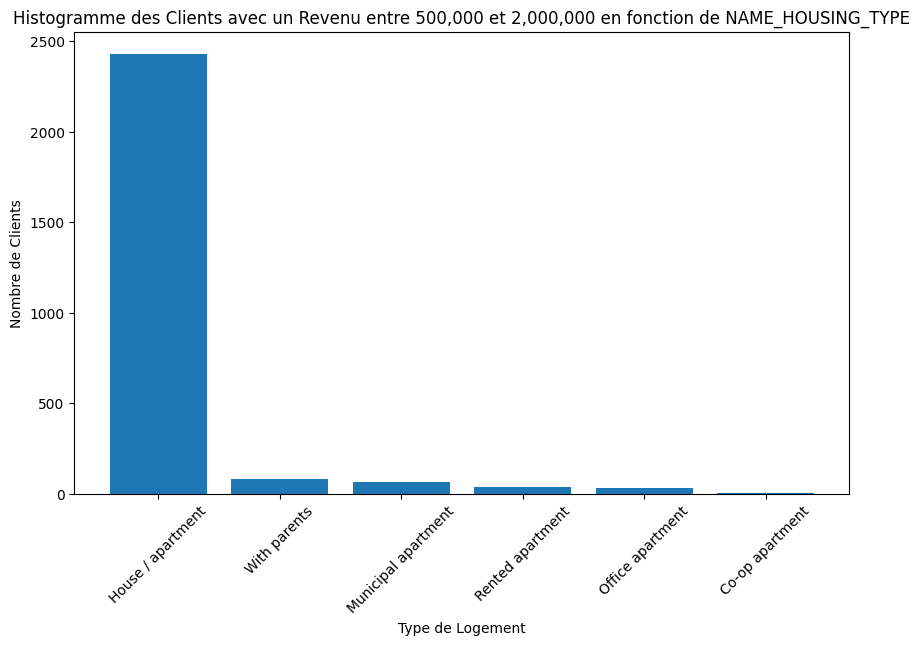

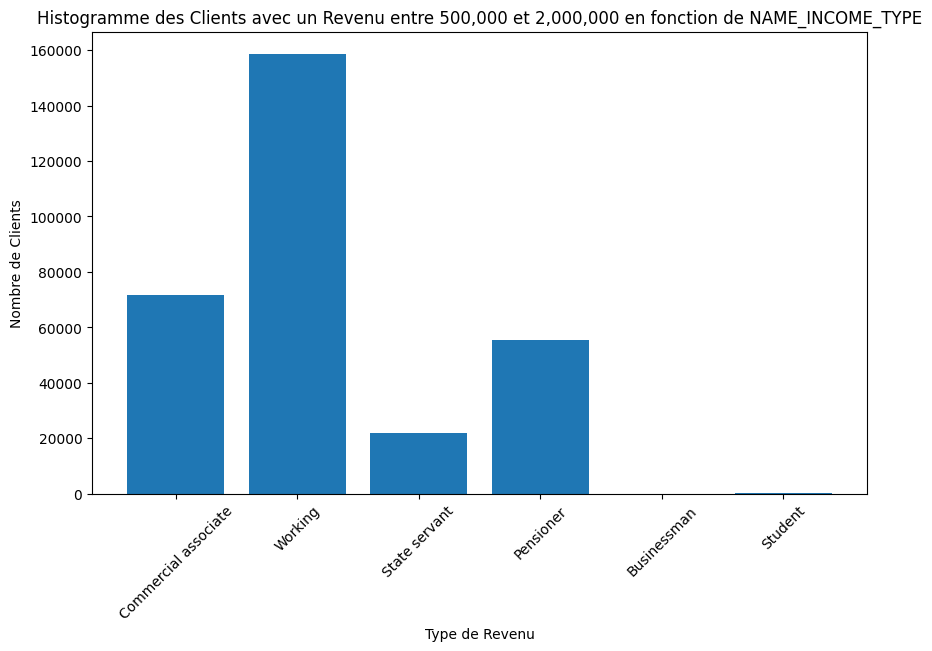

In [26]:
import matplotlib.pyplot as plt

# Vérifier que les colonnes 'NAME_HOUSING_TYPE' et 'NAME_INCOME_TYPE' existent dans le DataFrame 'df'
if 'NAME_HOUSING_TYPE' in df.columns and 'NAME_INCOME_TYPE' in df.columns:
    # Filtrer les clients ayant un revenu entre 500 000 et 2 000 000
    df_high_income = df[(df['AMT_INCOME_TOTAL'] > 500000) & (df['AMT_INCOME_TOTAL'] <= 2000000)]

    # Afficher l'histogramme des clients ayant un revenu de plus de 500 000 en fonction du montant de leur crédit
    plt.figure(figsize=(10, 6))
    plt.hist(df_high_income['AMT_CREDIT'], bins=20)
    plt.xlabel('Montant du Crédit')
    plt.ylabel('Nombre de Clients')
    plt.title('Histogramme des Clients avec un Revenu entre 500,000 et 2,000,000 en fonction du Montant de Crédit')
    plt.show()

    # Afficher l'histogramme des clients ayant un revenu de plus de 500 000 en fonction de NAME_HOUSING_TYPE
    plt.figure(figsize=(10, 6))
    plt.bar(df['NAME_HOUSING_TYPE'].value_counts().index, df_high_income['NAME_HOUSING_TYPE'].value_counts())
    plt.xlabel('Type de Logement')
    plt.ylabel('Nombre de Clients')
    plt.title('Histogramme des Clients avec un Revenu entre 500,000 et 2,000,000 en fonction de NAME_HOUSING_TYPE')
    plt.xticks(rotation=45)
    plt.show()

    # Réindexer df['NAME_INCOME_TYPE'].value_counts() avec les catégories de df_high_income['NAME_INCOME_TYPE'].value_counts()
    income_type_counts_reindexed = df['NAME_INCOME_TYPE'].value_counts().reindex(df_high_income['NAME_INCOME_TYPE'].value_counts().index)

    # Afficher l'histogramme des clients ayant un revenu de plus de 500 000 en fonction de NAME_INCOME_TYPE
    plt.figure(figsize=(10, 6))
    plt.bar(income_type_counts_reindexed.index, income_type_counts_reindexed)
    plt.xlabel('Type de Revenu')
    plt.ylabel('Nombre de Clients')
    plt.title('Histogramme des Clients avec un Revenu entre 500,000 et 2,000,000 en fonction de NAME_INCOME_TYPE')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Les colonnes 'NAME_HOUSING_TYPE' et 'NAME_INCOME_TYPE' ne sont pas présentes dans le DataFrame 'df'. Veuillez vérifier les noms de colonne.")


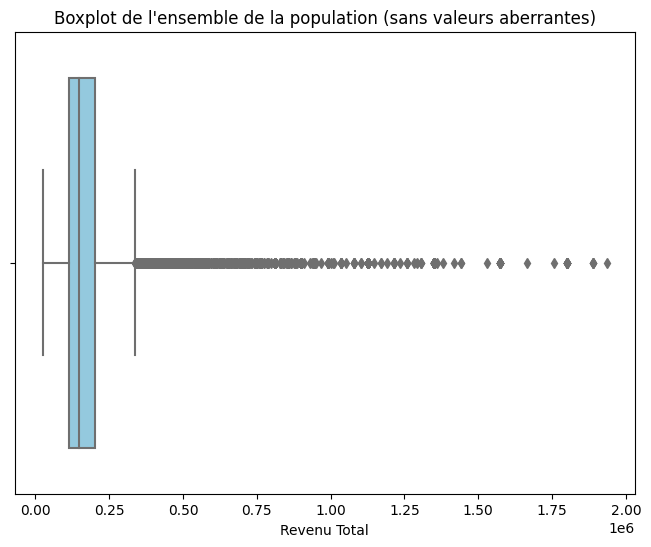

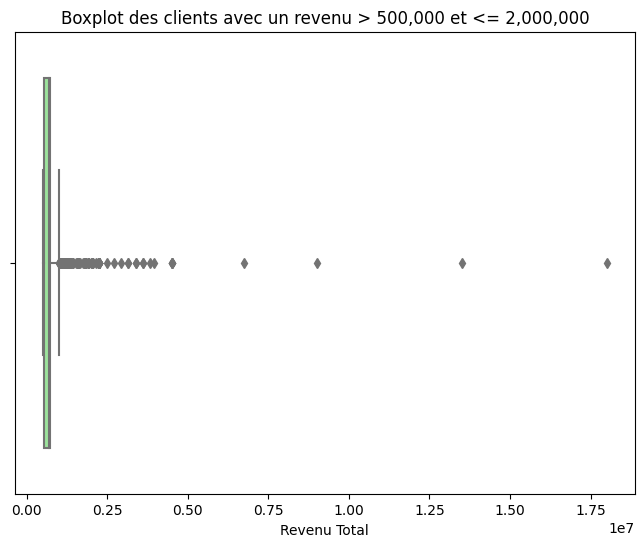

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrer les clients ayant un revenu de plus de 500 000 et inférieur ou égal à 20 000 000
df_high_income = df[(df['AMT_INCOME_TOTAL'] > 500000) & (df['AMT_INCOME_TOTAL'] <= 20000000)]

# Filtrer l'ensemble de la population avec un revenu inférieur ou égal à 2 000 000
df_all_population = df[df['AMT_INCOME_TOTAL'] <= 2000000]

# Créer le boxplot pour l'ensemble de la population
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_all_population['AMT_INCOME_TOTAL'], color='skyblue')
plt.xlabel('Revenu Total')
plt.title('Boxplot de l\'ensemble de la population (sans valeurs aberrantes)')
plt.show()

# Créer le boxplot pour les clients ayant un revenu de plus de 500 000 et inférieur ou égal à 20 000 000
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_high_income['AMT_INCOME_TOTAL'], color='lightgreen')
plt.xlabel('Revenu Total')
plt.title('Boxplot des clients avec un revenu > 500,000 et <= 2,000,000')
plt.show()


On va revenir ainsi sur le dataset encodé train_df et exclure une valeur de revenu supérieur à 2 000 000$. Mais il faudra faire ca avant d'encoder.

In [28]:
app_train.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes', 'TARGET',
       'DAYS_EMPLOYED_ANOM'],
      dtype='object', length=241)

### Corrélations

Maintenant que nous avons traité les variables catégorielles et les valeurs aberrantes, poursuivons l'exploration. Une façon d'essayer de comprendre les données est de rechercher des corrélations entre les caractéristiques et la cible. Nous pouvons calculer le coefficient de corrélation de Pearson entre chaque variable et la cible en utilisant la méthode .corr du dataframe.

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la "pertinence" d'une caractéristique, mais il nous donne une idée des relations possibles au sein des données. Quelques interprétations générales de la valeur absolue du coefficient de corrélation sont :

* 00-.19 “very weak”
* 20-.39 “weak”
* 40-.59 “moderate”
* 60-.79 “strong”
* 80-1.0 “very strong”

In [29]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Jetons un coup d'œil à certaines des corrélations les plus significatives: DAYS_BIRTH est la corrélation la plus positive. (à l'exception de TARGET car la corrélation d'une variable avec elle-même est toujours de 1!) En regardant la documentation, DAYS_BIRTH est l'âge en jours du client au moment du prêt en jours négatifs. La corrélation est positive, mais la valeur de cette caractéristique est en fait négative, ce qui signifie qu'à mesure que le client vieillit, il est moins susceptible de faire défaut sur son prêt (c'est-à-dire que la cible == 0). C'est un peu déroutant! cependant compte tenu de la transformation faite plus haut où nous avions divisé par -365 jours pour avoir un age cohérent, nous prendrons la valeur absolue de la caractéristique et ensuite la corrélation sera négative.

#### Effect of Age on Repayment

In [30]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

À mesure que le client vieillit, il existe une relation linéaire négative avec la cible, ce qui signifie qu'à mesure que les clients vieillissent, ils ont tendance à rembourser leurs prêts à temps plus souvent.

Commençons à examiner cette variable. Tout d'abord, nous pouvons faire un histogramme de l'âge. Nous mettrons l'axe des x en années pour rendre le graphique un peu plus compréhensible.

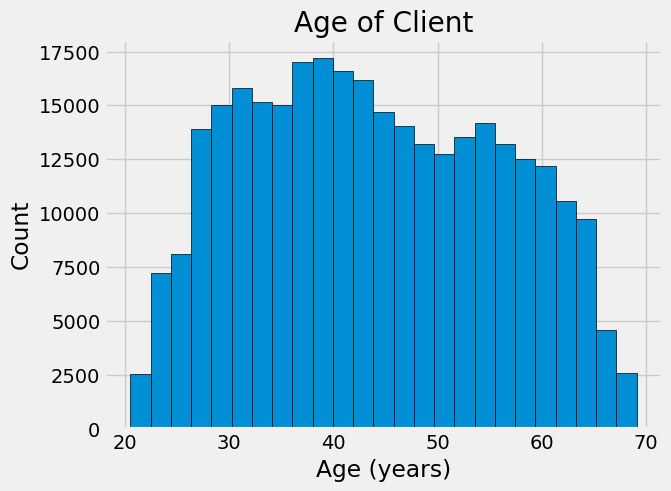

In [31]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

La distribution de l'âge ne nous dit pas grand-chose, sauf qu'il n'y a pas de valeurs aberrantes car tous les âges sont raisonnables. Pour visualiser l'effet de l'âge sur la cible, nous allons ensuite faire un graphique d'estimation de densité de noyau (KDE) coloré par la valeur de la cible. 

Un graphique d'estimation de densité de noyau montre la distribution d'une seule variable et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement un gaussien, à chaque point de données, puis en moyennant tous les noyaux individuels pour développer une seule courbe lisse). Nous utiliserons le kdeplot de seaborn pour ce graphique."

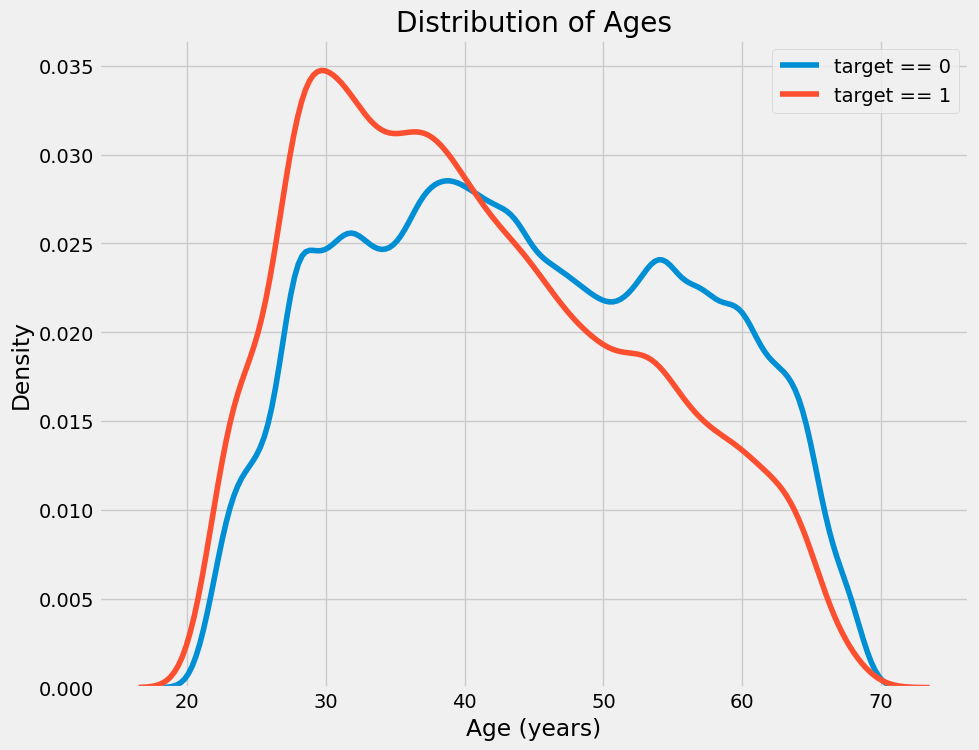

In [32]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

plt.legend()

La courbe cible == 1 se décale vers la partie la plus jeune de la plage. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable va probablement être utile dans un modèle d'apprentissage automatique car elle affecte la cible. Regardons cette relation d'une autre manière: échec moyen à rembourser les prêts par tranche d'âge.

Pour faire ce graphique, nous divisons d'abord la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque tranche, nous calculons la valeur moyenne de la cible, qui nous indique le rapport des prêts qui n'ont pas été remboursés dans chaque catégorie d'âge."

In [33]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']].copy()
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20, 70, num=11))
age_data.head(10)


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [34]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


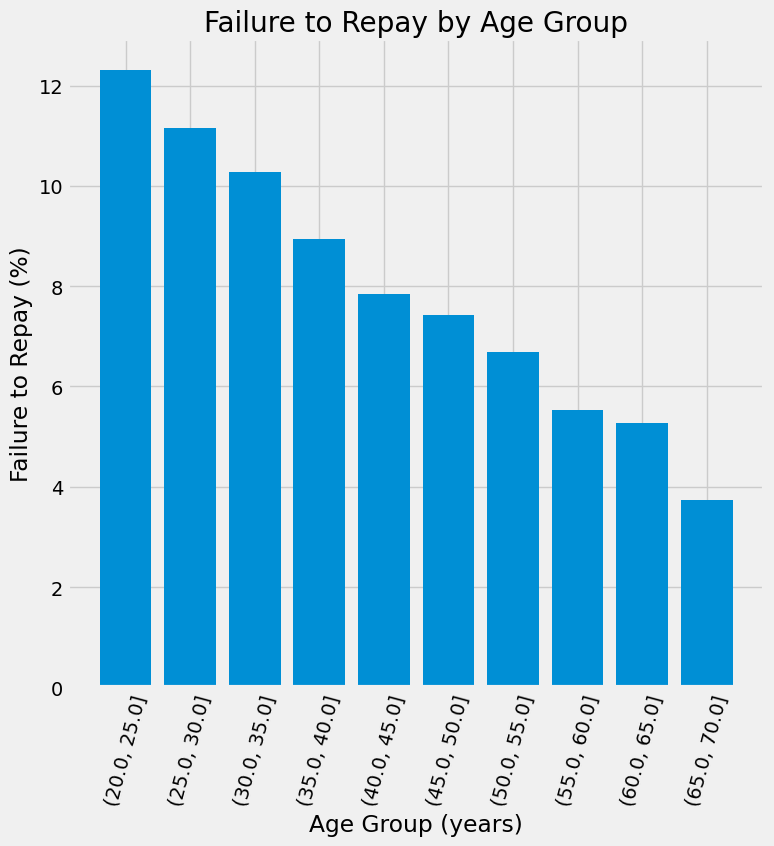

In [35]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

Il y a une tendance claire: les candidats plus jeunes sont plus susceptibles de ne pas rembourser le prêt! Le taux d'échec de remboursement est supérieur à 10% pour les trois groupes d'âge les plus jeunes et inférieur à 5% pour le groupe d'âge le plus âgé.

Ces informations pourraient être directement utilisées par la banque: comme les clients plus jeunes sont moins susceptibles de rembourser le prêt, peut-être devraient-ils bénéficier de plus de conseils ou de conseils en planification financière. Cela ne signifie pas que la banque devrait discriminer les clients plus jeunes, mais il serait judicieux de prendre des mesures préventives pour aider les clients plus jeunes à payer à temps.

#### Exterior Sources

Les 3 variables ayant les corrélations négatives les plus fortes avec la cible sont EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3. Selon la documentation, ces caractéristiques représentent un "score normalisé provenant d'une source de données externe". Je ne suis pas sûr de ce que cela signifie exactement, mais il peut s'agir d'une sorte de cote de crédit cumulative établie à l'aide de nombreuses sources de données.

Examinons ces variables.
Tout d'abord, nous pouvons montrer les corrélations des caractéristiques EXT_SOURCE avec la cible et entre elles."

In [36]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(50.583333333333314, 0.5, 'Variable')

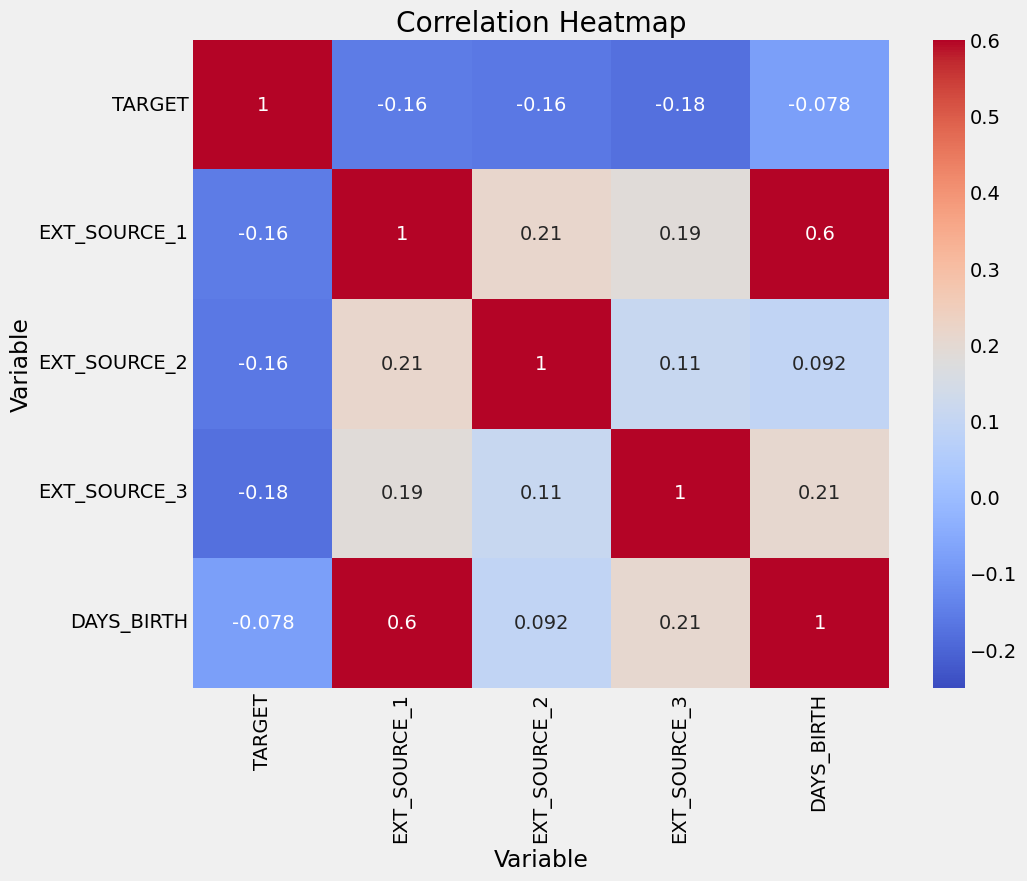

In [37]:
plt.figure(figsize=(10, 8))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap='coolwarm', vmin=-0.25, annot=True, vmax=0.6)

# Labeling of plot
plt.title('Correlation Heatmap')
plt.xlabel('Variable')
plt.ylabel('Variable')


Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, indiquant que lorsque la valeur de EXT_SOURCE augmente, le client est plus susceptible de rembourser le prêt. Nous pouvons également voir que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, indiquant que peut-être l'un des facteurs de ce score est l'âge du client.

Ensuite, nous pouvons examiner la distribution de chacune de ces caractéristiques colorées par la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible."

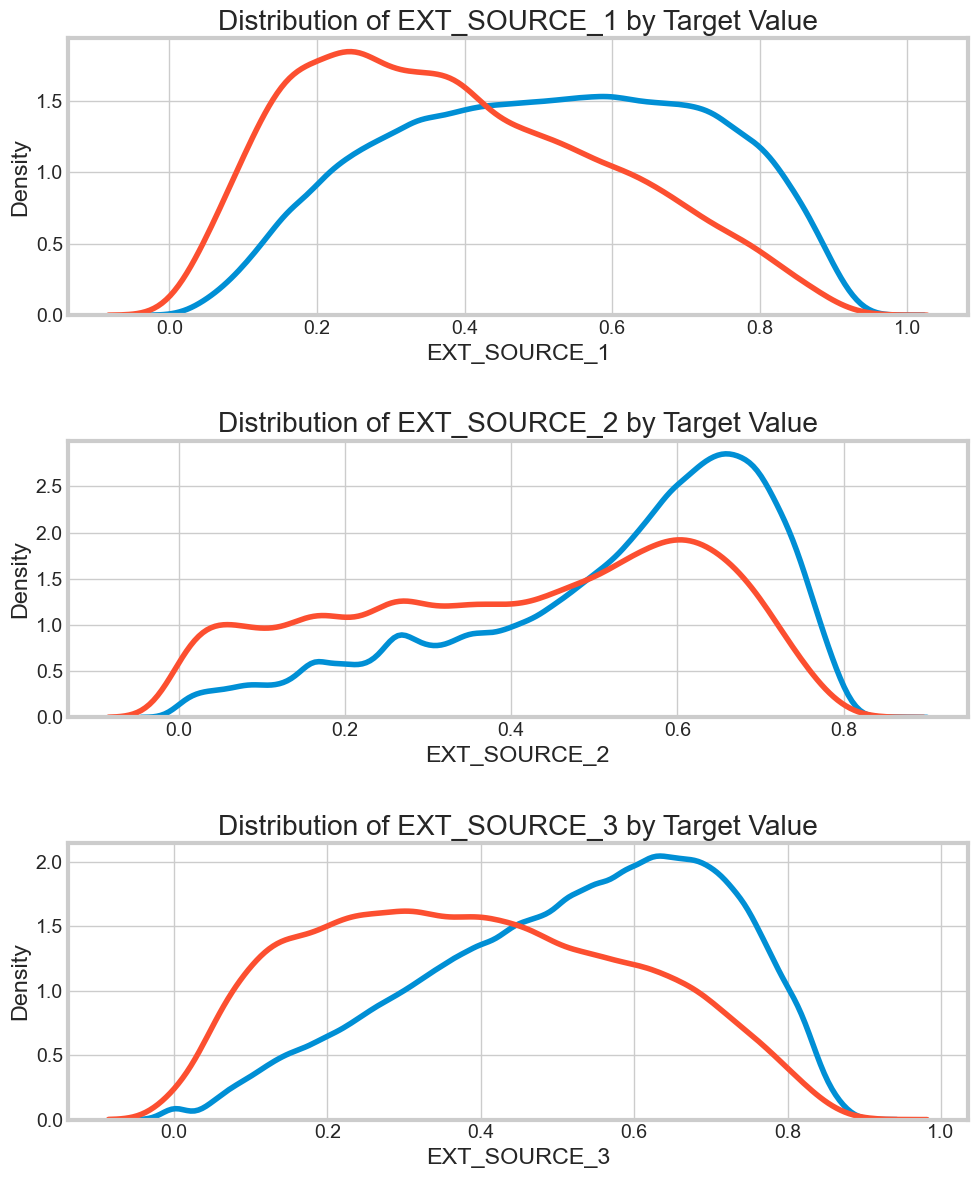

In [38]:
# Set the style of plots
sns.set_style('whitegrid')

plt.figure(figsize=(10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label='target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label='target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Density')
    
plt.tight_layout(h_pad=2.5)


EXT_SOURCE_3 affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte (en fait, elles sont toutes considérées comme très faibles), mais ces variables seront tout de même utiles pour un modèle d'apprentissage automatique afin de prédire si un demandeur remboursera ou non un prêt à temps.

#### Pairs Plot 

Comme dernière visualisation exploratoire, nous pouvons créer un graphique "Pairs Plot" des variables EXT_SOURCE et de la variable DAYS_BIRTH. Le Pairs Plot est un excellent outil d'exploration car il nous permet de voir les relations entre plusieurs paires de variables ainsi que les distributions des variables individuelles. Ici, nous utilisons la bibliothèque de visualisation seaborn et la fonction PairGrid pour créer un Pairs Plot avec des diagrammes de dispersion dans la partie supérieure, des histogrammes en diagonale, ainsi que des graphiques de densité 2D et des coefficients de corrélation dans la partie inférieure.

Text(0.5, 1.05, 'Ext Source and Age Features Pairs Plot')

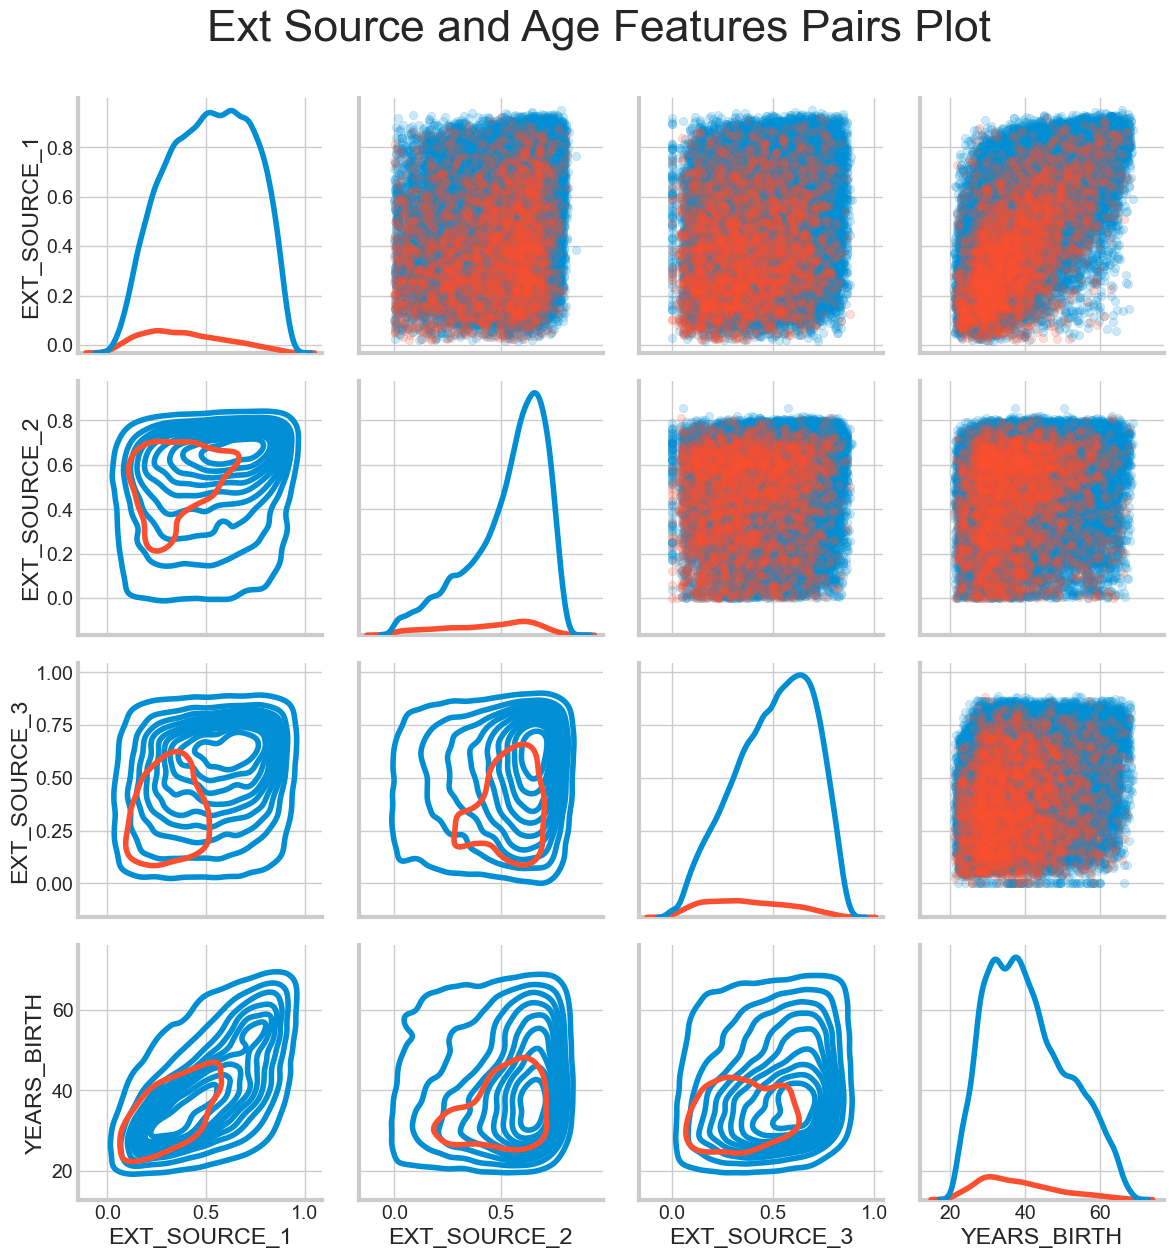

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Copy the data for plotting
plot_data = ext_data.drop(columns=['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size=20)

# Create the pairgrid object with the 'height' parameter instead of 'size'
grid = sns.PairGrid(data=plot_data, height=3, diag_sharey=False,
                    hue='TARGET',
                    vars=[x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha=0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot with a specific colormap
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)

plt.suptitle('Ext Source and Age Features Pairs Plot', size=32, y=1.05)


Dans ce graphique, le rouge indique les prêts qui n'ont pas été remboursés et le bleu représente les prêts qui ont été remboursés. Nous pouvons observer les différentes relations au sein des données. Il semble y avoir une relation linéaire positive modérée entre EXT_SOURCE_1 et DAYS_BIRTH (ou équivalemment YEARS_BIRTH), ce qui suggère que cette caractéristique pourrait prendre en compte l'âge du client.

# Feature Engineering

L'ingénierie des fonctionnalités offre un meilleur retour sur investissement que la construction du modèle et l'ajustement des hyperparamètres. Cet article aborde très bien le sujet). 

Bien que le choix du bon modèle et des paramètres optimaux soit important, le modèle ne peut apprendre que des données qui lui sont fournies. S'assurer que ces données sont aussi pertinentes que possible pour la tâche est le travail du scientifique des données (et peut-être de certains outils automatisés pour nous aider).

L'ingénierie des fonctionnalités fait référence à un processus général et peut impliquer à la fois la construction de fonctionnalités : ajouter de nouvelles fonctionnalités à partir des données existantes, et la sélection de fonctionnalités : choisir uniquement les fonctionnalités les plus importantes ou d'autres méthodes de réduction de dimension. Il existe de nombreuses techniques que nous pouvons utiliser pour créer et sélectionner des fonctionnalités.

Dans ce notebook, nous essayerons seulement deux méthodes de construction de fonctionnalités simples :

* Fonctionnalités polynomiales
* Fonctionnalités basées sur des connaissances spécifiques au domaine.

## Polynomial Features Engineering

Une méthode simple de construction de fonctionnalités s'appelle les "fonctionnalités polynomiales". Dans cette méthode, nous créons des fonctionnalités qui sont des puissances des fonctionnalités existantes, ainsi que des termes d'interaction entre les fonctionnalités existantes. Par exemple, nous pouvons créer des variables comme EXT_SOURCE_1^2 et EXT_SOURCE_2^2, ainsi que des variables telles que EXT_SOURCE_1 x EXT_SOURCE_2, EXT_SOURCE_1 x EXT_SOURCE_2^2, EXT_SOURCE_1^2 x EXT_SOURCE_2^2, et ainsi de suite. Ces fonctionnalités qui sont une combinaison de plusieurs variables individuelles sont appelées "termes d'interaction" car elles capturent les interactions entre les variables. En d'autres termes, alors que deux variables prises séparément peuvent ne pas avoir une forte influence sur la cible, les combiner en une seule variable d'interaction pourrait révéler une relation avec la cible. Les termes d'interaction sont couramment utilisés dans les modèles statistiques pour capturer les effets de plusieurs variables, mais je ne les vois pas utilisés aussi souvent en apprentissage automatique. Néanmoins, nous pouvons en essayer quelques-uns pour voir s'ils peuvent aider notre modèle à prédire si un client remboursera ou non un prêt.


Dans le code suivant, nous créons des fonctionnalités polynomiales en utilisant les variables EXT_SOURCE et la variable DAYS_BIRTH. Scikit-Learn dispose d'une classe utile appelée "PolynomialFeatures" qui crée les polynômes et les termes d'interaction jusqu'à un degré spécifié. Nous pouvons utiliser un degré de 3 pour voir les résultats (lorsque nous créons des fonctionnalités polynomiales, nous voulons éviter d'utiliser un degré trop élevé, à la fois parce que le nombre de fonctionnalités croît de manière exponentielle avec le degré, et parce que nous pouvons rencontrer des problèmes de surajustement(https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py)).

In [40]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [41]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


Cela crée un nombre considérable de nouvelles fonctionnalités. Pour obtenir les noms, nous devons utiliser la méthode get_feature_names des fonctionnalités polynomiales.

In [42]:
# Vos fonctionnalités d'entrée
input_features = np.array(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

# Obtenez les noms des fonctionnalités transformées
poly_feature_names = [f"{input_features[i]}_{input_features[j]}" for i in range(len(input_features)) for j in range(i, len(input_features))]

# Affichez les 15 premiers noms de fonctionnalités
print(poly_feature_names[:15])

['EXT_SOURCE_1_EXT_SOURCE_1', 'EXT_SOURCE_1_EXT_SOURCE_2', 'EXT_SOURCE_1_EXT_SOURCE_3', 'EXT_SOURCE_1_DAYS_BIRTH', 'EXT_SOURCE_2_EXT_SOURCE_2', 'EXT_SOURCE_2_EXT_SOURCE_3', 'EXT_SOURCE_2_DAYS_BIRTH', 'EXT_SOURCE_3_EXT_SOURCE_3', 'EXT_SOURCE_3_DAYS_BIRTH', 'DAYS_BIRTH_DAYS_BIRTH']


In [43]:
poly_transformer.get_feature_names_out(input_features)[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [44]:
# Par la ligne suivante pour utiliser get_feature_names_out :
feature_names_out = poly_transformer.get_feature_names_out(input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])
feature_names = feature_names_out[:15]

# Afficher les noms des 15 premières nouvelles fonctionnalités
print(feature_names)

['1' 'EXT_SOURCE_1' 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'DAYS_BIRTH'
 'EXT_SOURCE_1^2' 'EXT_SOURCE_1 EXT_SOURCE_2' 'EXT_SOURCE_1 EXT_SOURCE_3'
 'EXT_SOURCE_1 DAYS_BIRTH' 'EXT_SOURCE_2^2' 'EXT_SOURCE_2 EXT_SOURCE_3'
 'EXT_SOURCE_2 DAYS_BIRTH' 'EXT_SOURCE_3^2' 'EXT_SOURCE_3 DAYS_BIRTH'
 'DAYS_BIRTH^2']


Il y a 35 fonctionnalités avec les caractéristiques individuelles élevées à des puissances jusqu'au degré 3, ainsi que des termes d'interaction. Maintenant, nous pouvons vérifier si certaines de ces nouvelles fonctionnalités sont corrélées avec la cible.

In [45]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(input_features))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))



EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Plusieurs des nouvelles variables ont une corrélation plus grande (en termes de magnitude absolue) avec la cible que les caractéristiques originales. Lorsque nous construisons des modèles d'apprentissage automatique, nous pouvons essayer avec et sans ces fonctionnalités pour déterminer si elles aident réellement le modèle à apprendre.

Nous ajouterons ces fonctionnalités à une copie des données d'entraînement et de test, puis nous évaluerons les modèles avec et sans les fonctionnalités. Bien souvent, en apprentissage automatique, la seule façon de savoir si une approche fonctionnera est de l'essayer !

In [46]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


### Caractéristiques basées sur les connaissances du domaine

Il est peut-être inexact de les appeler "connaissances du domaine" car je ne suis pas un expert en crédit, mais nous pourrions les qualifier de "tentatives d'application de connaissances financières limitées". Dans cet état d'esprit, nous pouvons créer quelques fonctionnalités qui tentent de capturer ce que nous pensons être important pour déterminer si un client va faire défaut sur un prêt. Ici, je vais utiliser cinq fonctionnalités inspirées de ce script d'Aguiar :

* CREDIT_INCOME_PERCENT : le pourcentage du montant du crédit par rapport au revenu du client
* ANNUITY_INCOME_PERCENT : le pourcentage de l'annuité du prêt par rapport au revenu du client
* CREDIT_TERM : la durée du paiement en mois (puisque l'annuité est le montant mensuel dû)
* DAYS_EMPLOYED_PERCENT : le pourcentage de jours employés par rapport à l'âge du client


In [47]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [48]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

visualisons la distribution des nouvelles variables

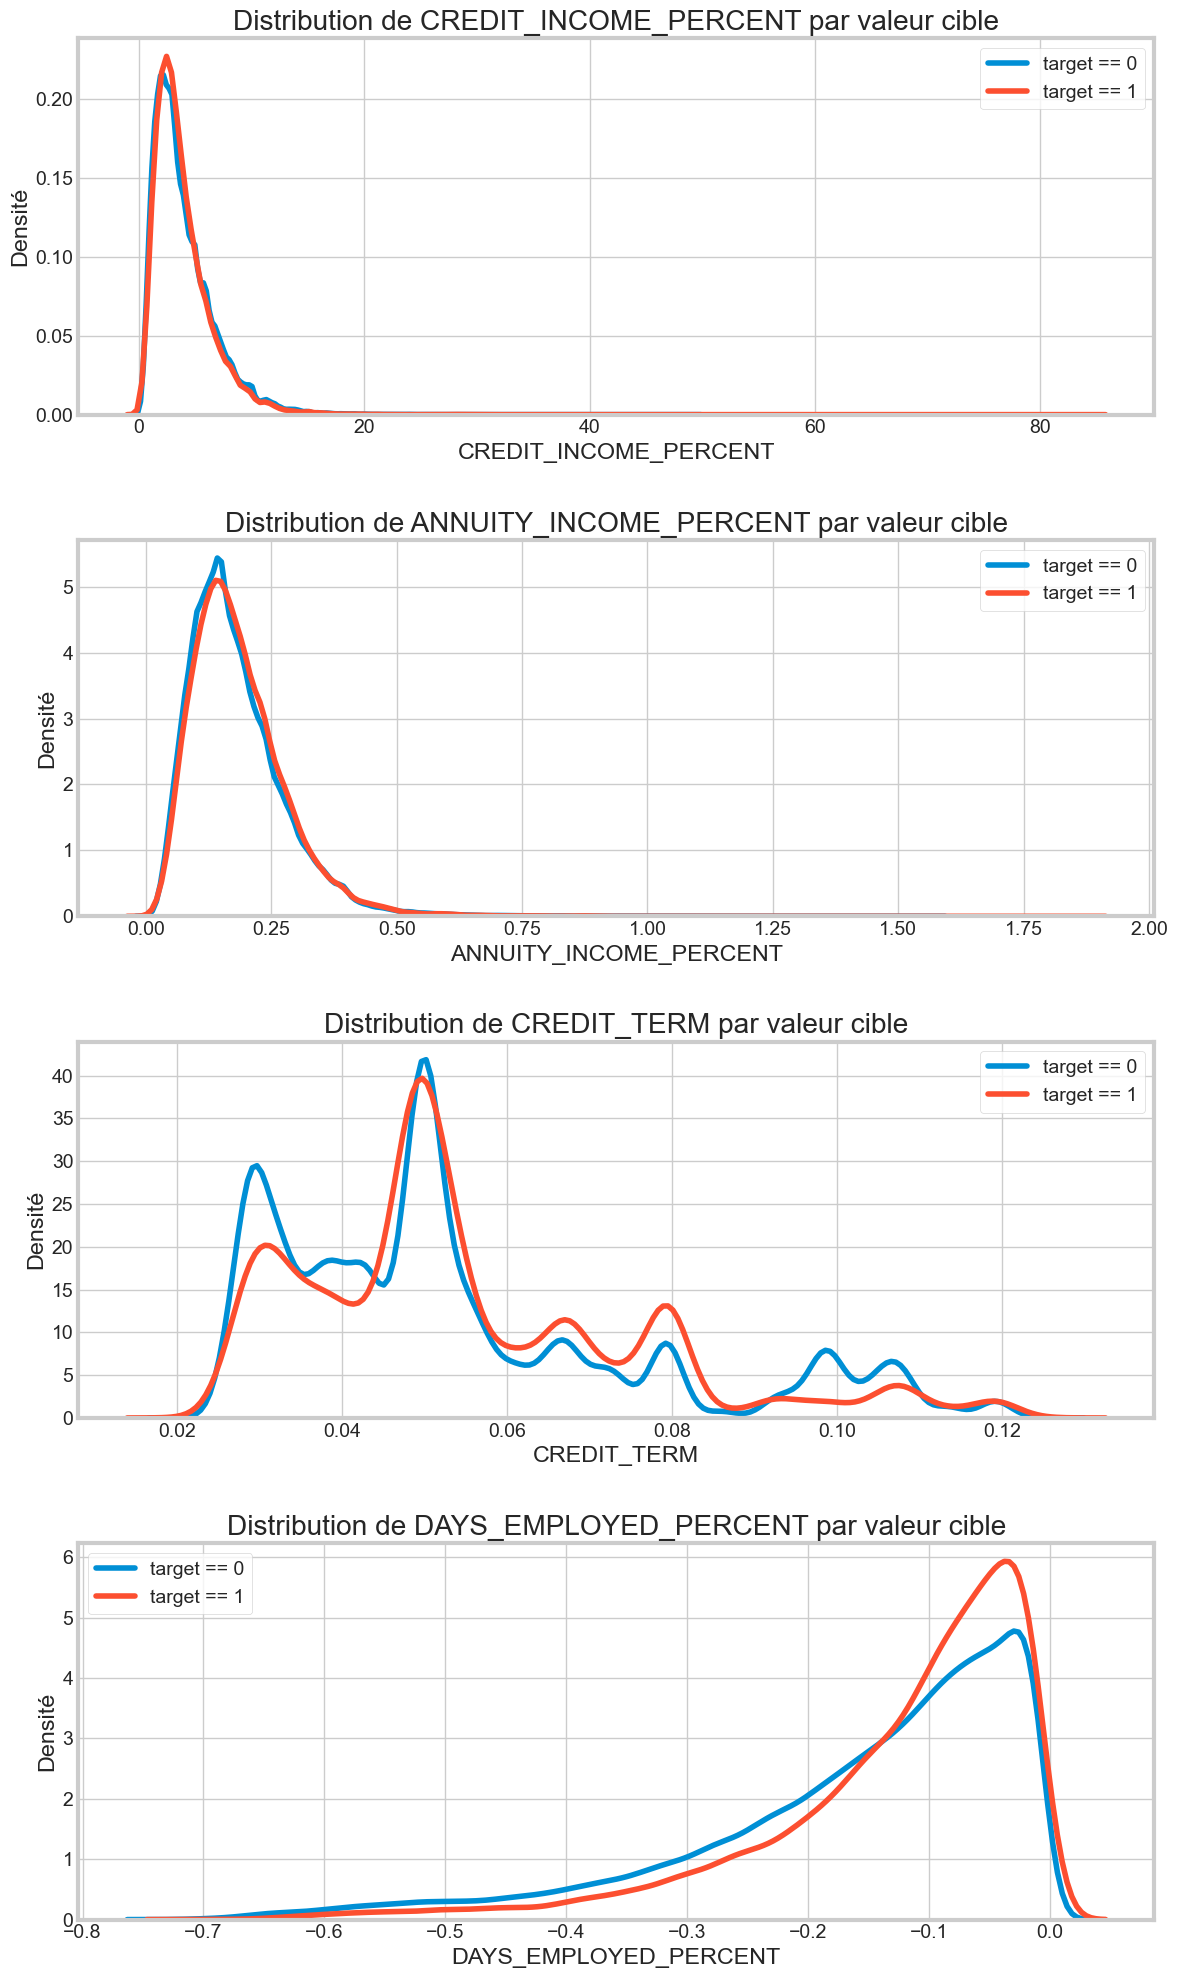

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Définir le style des graphiques comme étant "whitegrid"
sns.set_style('whitegrid')

plt.figure(figsize=(12, 20))
# Itérer à travers les nouvelles fonctionnalités
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):

    # Créer un nouveau subplot pour chaque caractéristique
    plt.subplot(4, 1, i + 1)
    # Tracer les prêts remboursés
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label='target == 0')
    # Tracer les prêts qui n'ont pas été remboursés
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label='target == 1')

    # Légende
    plt.legend()

    # Ajouter des étiquettes aux graphiques
    plt.title('Distribution de %s par valeur cible' % feature)
    plt.xlabel('%s' % feature)
    plt.ylabel('Densité')

plt.tight_layout(h_pad=2.5)
plt.show()


Il est difficile de dire à l'avance si ces nouvelles fonctionnalités seront utiles. La seule façon de le savoir avec certitude est de les essayer !

### Ligne de base (Baseline)¶
Pour une ligne de base naïve, nous pourrions supposer la même valeur pour tous les exemples dans l'ensemble de test. On nous demande de prédire la probabilité de non-remboursement du prêt, donc si nous ne sommes pas du tout sûrs, nous pourrions supposer 0.5 pour toutes les observations de l'ensemble de test. Cela nous donnera une aire sous la courbe du récepteur d'opérations (AUC ROC) de 0.5 dans la compétition (une prédiction aléatoire pour une tâche de classification obtiendra un score de 0.5).

Étant donné que nous savons déjà quel score nous allons obtenir, nous n'avons pas vraiment besoin de faire une supposition naïve pour la ligne de base. Utilisons un modèle légèrement plus sophistiqué pour notre ligne de base réelle : la régression logistique.

### Implémentation de la régression logistique
Ici, je vais me concentrer sur l'implémentation du modèle plutôt que d'expliquer les détails, mais pour ceux qui souhaitent en savoir plus sur la théorie des algorithmes d'apprentissage automatique, je recommande à la fois "An Introduction to Statistical Learning" et "Hands-On Machine Learning with Scikit-Learn and TensorFlow"(https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/). Ces deux livres présentent la théorie ainsi que le code nécessaire pour créer les modèles (en R et Python respectivement). Ils enseignent tous les deux avec l'idée que la meilleure façon d'apprendre est de pratiquer, et ils sont très efficaces !

Pour obtenir une ligne de base, nous utiliserons toutes les fonctionnalités après avoir encodé les variables catégorielles. Nous prétraiterons les données en complétant les valeurs manquantes (imputation) et en normalisant la plage des fonctionnalités (mise à l'échelle des fonctionnalités). Le code suivant effectue ces deux étapes de prétraitement.

In [50]:
def display_scree_plot(acp):
    scree = acp.explained_variance_ratio_*100
    #print(scree)
    #print("Le premier plan factoriel représente {} % de la variance totale.".format(round(scree[0] + scree[1],2)))
    #print("Le deuxième plan factoriel représente {} % de la variance totale.".format(round(scree[2] + scree[3],2)))
    #print("Le troisième plan factoriel représente {} % de la variance totale.".format(round(scree[4] + scree[5],2)))
    plt.figure(figsize=(8, 8))
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [51]:
def application_pca(df, taux=0.9):
    
    #n_comp = 40
    pca = PCA(taux)

    X_pca =  pd.DataFrame(pca.fit_transform(df))

    #On appelle la fonction qui trace la courbe des éboulis des valeurs propres
    display_scree_plot(pca)

    return X_pca

In [52]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def preprocesseur(df_train, df_test):
    # Sauvegardez les noms de colonnes d'origine
    column_names0 = df_train.columns.tolist()
    column_names1 = df_test.columns.tolist()

    # Drop the target from the training data and save it separately
    if "TARGET" in df_train:
        target = df_train["TARGET"]
        train = df_train.drop(columns=["TARGET"])
    else:
        train = df_train.copy()

    # Median imputation of missing values
    imputer = SimpleImputer(strategy='median')

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Replace the boolean column by numeric values
    train["DAYS_EMPLOYED_ANOM"] = train["DAYS_EMPLOYED_ANOM"].astype("int")

    # Fit on the training data
    imputer.fit(train)

    # Transform both training and testing data
    train = imputer.transform(train)
    test = imputer.transform(df_test)

    # Repeat with the scaler
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)

    # Créez un nouveau DataFrame avec les données transformées et les noms de colonnes d'origine
    train_df = pd.DataFrame(train, columns=column_names0[:-1])  # Exclure la colonne "TARGET"
    test_df = pd.DataFrame(test, columns=column_names1)

    #if "TARGET" in df_train:
        #train_df["TARGET"] = target  # Réaffectez la colonne "TARGET" à train_df

    return train_df, test_df

In [53]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def preprocesseur1(df_train, df_test):
    # Sauvegardez les noms de colonnes d'origine
    column_names = df_train.columns.tolist()
    

    # Drop the target from the training data and save it separately
    if "TARGET" in df_train:
        target = df_train["TARGET"]
        train = df_train.drop(columns=["TARGET"])
    else:
        train = df_train.copy()

    # Median imputation of missing values
    imputer = SimpleImputer(strategy='median')

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Replace the boolean column by numeric values
    train["DAYS_EMPLOYED_ANOM"] = train["DAYS_EMPLOYED_ANOM"].astype("int")

    # Fit on the training data
    imputer.fit(train)

    # Transform both training and testing data
    train = imputer.transform(train)
    test = imputer.transform(df_test)

    # Repeat with the scaler
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)

    # Créez un nouveau DataFrame avec les données transformées et les noms de colonnes d'origine
    train_df = pd.DataFrame(train, columns=column_names)  # Exclure la colonne "TARGET"
    test_df = pd.DataFrame(test, columns=column_names)

    #if "TARGET" in df_train:
        #train_df["TARGET"] = target  # Réaffectez la colonne "TARGET" à train_df

    return train_df, test_df

In [54]:
def echantillonage(df_X, df_y):

    X = df_X.copy()
    y = df_y.copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    return X_train, X_test, y_train, y_test

In [55]:
# Vérifiez si 'SK_ID_CURR' est une colonne dans le DataFrame
if 'SK_ID_CURR' in app_test.columns:
    print("La colonne 'SK_ID_CURR' existe dans le DataFrame 'app_test'.")
else:
    print("La colonne 'SK_ID_CURR' n'existe pas dans le DataFrame 'app_test'.")

La colonne 'SK_ID_CURR' existe dans le DataFrame 'app_test'.


Avant de construire notre baseline, nous allons effectuer le preprocessing des données qui se compose en 3 fonctions :

* Echantillonage : Pour séparer notre dataset en 2 parties. Nous garderons les données de tests de côté afin d'être sûr que les modèles ne les voient pas dans une phase d'entraînement.

* Preprocesseur : Qui contient l'imputer, et le scaler.

* PCA : Pour effectuer une réduction dimensionnelle.

In [56]:
train_ids = app_train['SK_ID_CURR']

In [57]:
app_train0 = app_train.copy()
app_test0 = app_test.copy()

### Preprocessing + Echantillonage des données

Nous allons réaliser nos trois processings suivis des échantillonages correspondant à nos trois hypothèses de features engineering.

In [58]:
%%time

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


app_train.drop(columns="SK_ID_CURR", inplace=True)
app_test.drop(columns="SK_ID_CURR", inplace=True)

print("Preprocessing sans feature engineering")
train, test = preprocesseur(app_train, app_test)
print("Echantillonage : train = 80% | test = 20%")

X_train, X_test, y_train, y_test = echantillonage(train, app_train["TARGET"])
print("X_train shape :", X_train.shape)
print("X_test shape :", X_test.shape)
print("")

app_train_poly.drop(columns="SK_ID_CURR", inplace=True)
app_test_poly.drop(columns="SK_ID_CURR", inplace=True)

print("Preprocessing avec features polynomial")
train_poly, test_poly = preprocesseur1(app_train_poly, app_test_poly)
print("Echantillonage : train = 80% | test = 20%")

X_train_poly, X_test_poly, y_train_poly, y_test_poly = echantillonage(train_poly, app_train["TARGET"])
print("X_train shape :", X_train_poly.shape)
print("X_test shape :", X_test_poly.shape)
print("")

app_train_domain.drop(columns="SK_ID_CURR", inplace=True)
app_test_domain.drop(columns="SK_ID_CURR", inplace=True)

print("Preprocessing sans feature engineering")
train_domain, test_domain = preprocesseur(app_train_domain, app_test_domain)
print("Echantillonage : train = 80% | test = 20%")

X_train_domain, X_test_domain, y_train_domain, y_test_domain = echantillonage(train_domain, app_train["TARGET"])
print("X_train shape :", X_train_domain.shape)
print("X_test shape :", X_test_domain.shape)

print("Construction echantillonage d'étude")
X_train_etude = app_train.sample(50000)
y_train_etude = app_train["TARGET"][X_train_etude.index]

Preprocessing sans feature engineering
Echantillonage : train = 80% | test = 20%
X_train shape : (246008, 239)
X_test shape : (61503, 239)

Preprocessing avec features polynomial
Echantillonage : train = 80% | test = 20%
X_train shape : (246008, 274)
X_test shape : (61503, 274)

Preprocessing sans feature engineering
Echantillonage : train = 80% | test = 20%
X_train shape : (246008, 243)
X_test shape : (61503, 243)
Construction echantillonage d'étude
CPU times: total: 1min 15s
Wall time: 1min 26s


In [59]:
#print("Preprocessing avec features polynomial")
#train_poly, test_poly = preprocesseur(app_train_poly, app_test_poly)
#print("Echantillonage : train = 80% | test = 20%")
#print("Preprocessing sans feature engineering")
#train_domain, test_domain = preprocesseur(app_train_domain, app_test_domain)

In [60]:
train_df_domain = pd.DataFrame(train_domain)
train_df_domain.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM
0,0.0,0.0,1.0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.111161,...,0.0,1.0,0.0,1.0,0.0,0.0,0.023640,0.064910,0.377861,0.907618
1,0.0,0.0,0.0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.522886,...,0.0,0.0,0.0,1.0,0.0,0.0,0.056483,0.070368,0.053985,0.902771
2,1.0,1.0,1.0,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.651466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.023547,0.053193,0.272843,0.983791
3,0.0,0.0,1.0,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.649154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.027278,0.117114,0.711908,0.780594
4,0.0,0.0,1.0,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,0.701409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.049774,0.095823,0.200770,0.790867


In [61]:
app_train.columns

Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes', 'TARGET',
       'DAYS_EMPLOYED_ANOM'],
      dtype='object', length=240)

In [62]:
test_df = pd.DataFrame(test)
train_df = pd.DataFrame(train)

In [63]:
train_df.columns

Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed',
       'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others',
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'TARGET'],
      dtype='object', length=239)

Nous utiliserons LogisticRegression de Scikit-Learn pour notre premier modèle. La seule modification que nous apporterons aux paramètres par défaut du modèle consistera à réduire le paramètre de régularisation, C, qui contrôle le niveau de surapprentissage (une valeur plus basse devrait réduire le surapprentissage). Cela nous donnera des résultats légèrement meilleurs que ceux du modèle LogisticRegression par défaut, mais cela constituera tout de même une référence basse pour tous les futurs modèles.

Ici, nous utilisons la syntaxe familière de modélisation de Scikit-Learn : nous créons d'abord le modèle, puis nous l'entraînons à l'aide de .fit, et enfin nous effectuons des prédictions sur les données de test à l'aide de .predict_proba (n'oubliez pas que nous voulons des probabilités et non un 0 ou 1).

In [64]:
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


In [65]:
# separate training data
train_df['TARGET'] = app_train['TARGET'].astype(int)
train_dataset = train_df
target = train_dataset['TARGET']
features = train_dataset.drop(columns=['TARGET'], axis = 1)
print('x_train data shape: ', features.shape)
print('y_train data shape: ', target.shape)

x_train data shape:  (307511, 238)
y_train data shape:  (307511,)


In [66]:
train_dataset.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,0.0,0.0,1.0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.111161,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
1,0.0,0.0,0.0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.522886,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,1.0,1.0,1.0,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.651466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,1.0,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.649154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,1.0,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,0.701409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [67]:
features.columns

Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=238)

In [68]:
target_sample = target
target_sample.shape

(307511,)

In [69]:
features_sample = features
features_sample.shape

(307511, 238)

**Le prétraitement des données est le suivant:**

Fractionnement du jeu de données (30% test set).
Définir les attributs (numériques , catégoriques ...)
Compléter les données manquantes (Imputation):
Les variables numériques : Médiane (car variables asymétriques). Les variables catégoriques : le plus fréquent.

Mise à l'échelle des fonctionnalités (Robust scaler(plus fiable vis à vis des outliers)).
Encodage des données catégorielles.

In [70]:
# Train test Split
X_train, X_test, y_train, y_test = train_test_split(features_sample, target_sample, test_size = 0.4)

In [71]:
# Define categorical columns
categoric_attribute = list(features_sample.select_dtypes(exclude=["number"]).columns)
# Define numerical columns
numeric_attribute = list(features_sample.select_dtypes(exclude=["bool_","object_"]).columns)

In [72]:
# Pipeline data transformation (Imputation / Scaling / Encoding):
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

def Preprocessing (numeric,categoric):
    numeric_transfs = [('imputer',SimpleImputer(missing_values= np.NAN, strategy= 'median')),('scaler', RobustScaler())]
    numeric_pipeline = Pipeline(numeric_transfs)
    categoric_transfs = [('imputer',SimpleImputer(strategy="most_frequent")),('encoding', OneHotEncoder(dtype=int,sparse=True,handle_unknown='ignore'))]
    categoric_pipeline = Pipeline(categoric_transfs)
    all_transfs = [("numeric",numeric_pipeline,numeric),("categorical",categoric_pipeline,categoric)]
    full_preprocessor = ColumnTransformer(all_transfs, remainder='passthrough')
    return full_preprocessor

In [73]:
# Data Transformed
preprocessor_fitted = Preprocessing(numeric_attribute,categoric_attribute).fit(X_train)
X_train_transformed = preprocessor_fitted.transform(X_train)
X_test_transformed = preprocessor_fitted.transform(X_test)

In [74]:
X_train_transformed.shape

(184506, 238)

In [75]:
X_test_transformed.shape

(123005, 238)

### Logistic Regression

#### Hypothèse 1 - Sans feature engineering
Notre première itération est effectuée avec les sets X_train et X_test

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Créer le modèle avec le paramètre de régularisation spécifié
#log_reg = LogisticRegression(C=0.0001)

# Entraîner sur les données d'entraînement
#log_reg.fit(train, train_labels)

# Faire des prédictions
#log_reg_pred = log_reg.predict(test)  # Prédictions directes, pas besoin de probabilités ici


In [77]:
from sklearn.metrics import accuracy_score

# Assurez-vous que les vraies valeurs sont présentes dans le DataFrame submit
#true_labels = submit['TARGET']  # Vraies valeurs

# Calculer l'accuracy entre les prédictions et les vraies valeurs
#accuracy = accuracy_score(true_labels, log_reg_pred)

# Afficher l'accuracy
#print("Accuracy du modèle : {:.2f}%".format(accuracy * 100))


#### Hypothèse 2 - Avec polynomial features
Notre deuxième itération est effectuée avec les sets X_train_poly et X_test_poly

In [78]:
# On crée le dataframe de résultats
#df_results_base_poly = pd.DataFrame(y_test_poly.values, columns=["y_true"], index=y_test_poly.index)

# On lance les prédictions
#log_reg_pred = log_reg(X_train_poly, y_train_poly, y_test_poly, X_test_poly)

# On enregistre les résultats
#df_results_base_poly = save_results(df_results_base_poly, log_reg_pred, "y_pred_lr_poly", y_test_poly)

# On "binarise" les probabilités avec un treshold parametré à 0.5
# Par exemple, pour un treshold de 0.5, si la probabilité en est inférieure la valeur sera de 0. Sinon elle sera de 1.
# Et on concatène les données à notre tableau de résultats
#df_results_base_poly["y_pred_lr_poly_bin"] = transform_treshold(df_results_base_poly["y_pred_lr_poly"], 0.5)

#display(df_results_base_poly.head())
#print(df_results_base_poly.shape)

#### Hypothèse 3 - Avec domain knowledge features
Notre troisième itération est effectuée avec les sets X_train_domain et X_test_domain

In [79]:
# On crée le dataframe de résultats
#df_results_base_domain = pd.DataFrame(y_test_domain.values, columns=["y_true"], index=y_test_domain.index)

# On lance les prédictions
#log_reg_pred = log_reg(X_train_domain, y_train_domain, y_test_domain, X_test_domain)

# On enregistre les résultats
#df_results_base_domain = save_results(df_results_base_domain, log_reg_pred, "y_pred_lr_domain", y_test_domain)

# On "binarise" les probabilités avec un treshold parametré à 0.5
# Par exemple, pour un treshold de 0.5, si la probabilité en est inférieure la valeur sera de 0. Sinon elle sera de 1.
# Et on concatène les données à notre tableau de résultats
#df_results_base_domain["y_pred_lr_domain_bin"] = transform_treshold(df_results_base_domain["y_pred_lr_domain"], 0.5)

#display(df_results_base_domain.head())
#print(df_results_base_domain.shape)

#### Confusion matrix
An interesting way to evaluate the results is by means of a confusion matrix, which shows the correct and incorrect predictions for each class. In the first row, the first column indicates how many classes 0 were predicted correctly, and the second column, how many classes 0 were predicted as 1. In the second row, we note that all class 1 entries were erroneously predicted as class 0.

Therefore, the higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

In [80]:
def aff_confusion_matrix(df_true, df_pred):

    conf_mat = confusion_matrix(df_true, df_pred)

    print('Confusion matrix:\n', conf_mat)

    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

In [81]:
#from sklearn.metrics import confusion_matrix

#aff_confusion_matrix(df_results_base["y_true"], df_results_base["y_pred_lr_bin"])

#aff_confusion_matrix(df_results_base_poly["y_true"], df_results_base_poly["y_pred_lr_poly_bin"])

#aff_confusion_matrix(df_results_base_domain["y_true"], df_results_base_domain["y_pred_lr_domain_bin"])

Nous pouvons constater que, comme on pouvait le prévoir, l'accuracy du modèle est excellente, mais cela est dû au fait que le jeu de données est fortement déséquilibré.

En effet il n'y a pas une seule target = 1 qui ait été trouvé dans ce premier essai.

In [82]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#df_metrics_base = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1_score"], index=["sans_feat_eng", "poly_feat", "domain_feat"])

#df_metrics_base["Accuracy"][0] = round(accuracy_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
#df_metrics_base["Precision"][0] = round(precision_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
#df_metrics_base["Recall"][0] = round(recall_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
#df_metrics_base["F1_score"][0] = round(f1_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)

#df_metrics_base["Accuracy"][1] = round(accuracy_score(df_results_base_poly["y_true"], df_results_base_poly.iloc[:, 2]), 2)
#df_metrics_base["Precision"][1] = round(precision_score(df_results_base_poly["y_true"], df_results_base_poly.iloc[:, 2]), 2)
#df_metrics_base["Recall"][1] = round(recall_score(df_results_base_poly["y_true"], df_results_base_poly.iloc[:, 2]), 2)
#df_metrics_base["F1_score"][1] = round(f1_score(df_results_base_poly["y_true"], df_results_base_poly.iloc[:, 2]), 2)

#df_metrics_base["Accuracy"][2] = round(accuracy_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)
#df_metrics_base["Precision"][2] = round(precision_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)
#df_metrics_base["Recall"][2] = round(recall_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)
#df_metrics_base["F1_score"][2] = round(f1_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)

#df_metrics_base

Les premiers résultats nous indique que les targets à prédire étants très fortement déséquilibrées, le feature engineering essayé précédemment n'améliore rien du tout. Cela ne veut pas dire qu'il est inutile, mais vu le déséquilibrage des targets nous n'en voyons pas les effets.

Nous allons donc réessayer un faisant un resampling du jeu de données.

# Resampling

Dans le cas de données très déséquilibré comme ici, il existe des techniques de rééchantillonage afin de rééquilibrer ces données.

Exemple : Un jeu de données de 1000 individus, avec 90% de target=0 et 10% de target=1.

Imaginons que le modèle ne prédise que des 0. Il aura une accuracy de 90% au général, mais pour la classe 1 son accuracy sera de 0%. Le modèle ne sera donc pas si performant que ça.

Il existe deux techniques pour resampler les données :

* Le sous-échantillonnage aléatoire (random undersampling) des observations majoritaires : on retire aléatoirement des observations majoritaires  
* Le sur-échantillonnage aléatoire (random oversampling) des observations minoritaires : on tire au hasard des individus minoritaires que l’on rajoute aux données.  
* Le sur-échantillonnage synthétique (SMOTE pour Synthetic Minority Oversampling Technique) produit des observations minoritaires ressemblantes mais distinctes de celles déjà existantes.

L'idée est de combiner SMOTE avec une technique de sous-échantillonnage (ENN, Tomek) pour augmenter l'efficacité de la gestion de la classe déséquilibrée.

In [83]:
print("RAPPEL - DESEQUILIBRAGE DES DONNEES")

percent0 = (y_train.value_counts()[0] / y_train.shape) * 100
percent1 = (y_train.value_counts()[1] / y_train.shape) * 100

print("Nombre d'individus pour la classe 0 :", y_train.value_counts()[0], ". Soit", percent0, "% de la population.")
print("Nombre d'individus pour la classe 1 :", y_train.value_counts()[1], ". Soit", percent1, "% de la population.")

RAPPEL - DESEQUILIBRAGE DES DONNEES
Nombre d'individus pour la classe 0 : 169600 . Soit [91.92112994] % de la population.
Nombre d'individus pour la classe 1 : 14906 . Soit [8.07887006] % de la population.


Class 0: 169600
Class 1: 14906
Proportion: 11.38 : 1


([<matplotlib.patches.Wedge at 0x1d22578acd0>,
 [Text(-0.27619786300630345, -1.0647604145866578, 'Classe 0'),
  Text(0.3013066508904412, 1.1615568441230872, 'Classe 1')],
 [Text(-0.15065337982162003, -0.5807784079563587, '91.9%'),
  Text(0.17576221301942402, 0.6775748257384675, '8.1%')])

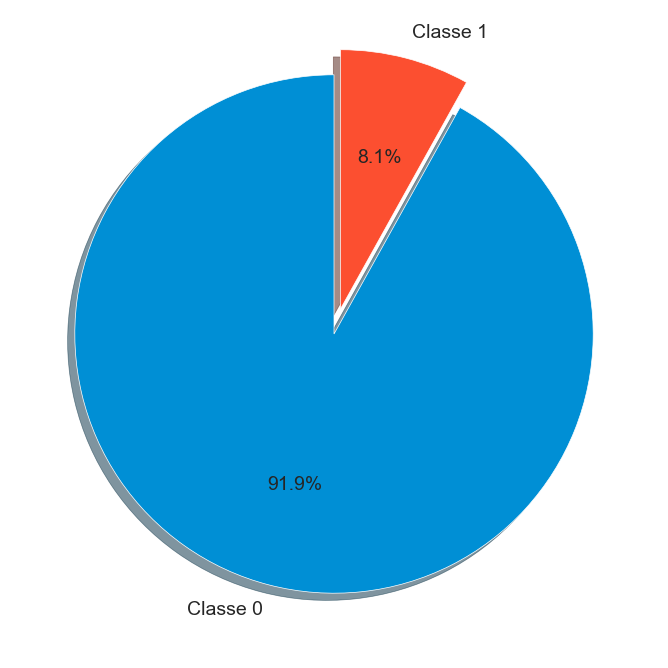

In [84]:
target_count = y_train.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

plt.figure(figsize=(8,8))

plt.pie(target_count, explode=[0, 0.1], labels=["Classe 0", "Classe 1"], autopct='%1.1f%%',
        shadow=True, startangle=90)

In [85]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


# define smote strategy
sm = SMOTE(random_state=42)

# Define SMOTE-Tomek Links (Over-sampling followed by under-sampling)
smtomek=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
# define oversampling strategy

oversample = RandomOverSampler(sampling_strategy='minority')

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

In [86]:
def resampling (features, target, resample):
    print('Original dataset shape %s' % Counter(target))
    X, y = resample.fit_resample(features, target)
    print('Resampled dataset shape %s' % Counter(y))
    return X, y

In [87]:
 X_train_sm,y_train_sm = resampling (X_train_transformed, y_train, sm)

Original dataset shape Counter({0: 169600, 1: 14906})
Resampled dataset shape Counter({0: 169600, 1: 169600})


In [88]:
X_train_smtomek,y_train_smtomek = resampling (X_train_transformed, y_train, smtomek)

Original dataset shape Counter({0: 169600, 1: 14906})
Resampled dataset shape Counter({1: 169600, 0: 169237})


In [89]:
X_test_smtomek,y_test_smtomek = resampling (X_test_transformed, y_test, smtomek)

Original dataset shape Counter({0: 113086, 1: 9919})
Resampled dataset shape Counter({1: 113086, 0: 112748})


**Reduisons la taille de l'échantillon pour accélérer le traiteemnt des modèles**

In [90]:
from sklearn.model_selection import train_test_split

# Divisez X_train_smtomek et y_train_smtomek en données d'entraînement et de validation (par exemple, 70% d'entraînement, 30% de validation)
X_train_smtomek, X_val_smtomek, y_train_smtomek, y_val_smtomek = train_test_split(
    X_train_smtomek, y_train_smtomek, test_size=0.6, random_state=42, stratify=y_train_smtomek
)

# Assurez-vous que la proportion des classes est conservée dans les données d'entraînement et de validation
print("Proportion des classes dans y_train_smtomek_etude :", Counter(y_train_smtomek))
print("Proportion des classes dans y_val_smtomek_etude   :", Counter(y_val_smtomek))

# Vous pouvez également faire de même avec X_test_smtomek
X_test_smtomek, _, y_test_smtomek, _ = train_test_split(
    X_test_smtomek, y_test_smtomek, test_size=0.6, random_state=42, stratify=y_test_smtomek
)

# Assurez-vous que la proportion des classes est conservée dans les données de test
print("Proportion des classes dans y_test_smtomek_etude  :", Counter(y_test_smtomek))


Proportion des classes dans y_train_smtomek_etude : Counter({1: 67840, 0: 67694})
Proportion des classes dans y_val_smtomek_etude   : Counter({1: 101760, 0: 101543})
Proportion des classes dans y_test_smtomek_etude  : Counter({1: 45234, 0: 45099})


In [91]:
pd.DataFrame(X_train_smtomek).to_csv('X_train_smtomek.csv',index=False)
pd.DataFrame(y_train_smtomek).to_csv('y_train_smtomek.csv',index=False)
pd.DataFrame(X_test_smtomek).to_csv('X_test_smtomek.csv',index=False)
pd.DataFrame(y_test_smtomek).to_csv('y_test_smtomek.csv',index=False)

# Mise en place et optimisation de modèles

Le but de cette partie est de trouver l'ensemble d'arguments de configuration de modèle spécifiques qui entraînent les meilleures performances du modèle .

La méthode d'optimisation des hyperparamètres est basée sur GRID SEARCH CV.

Métrique Spécifique
La métrique Bancaire consiste à calculer le gain obtenu pour l'ensemble des individus du jeu de données. Pour cela, on va pénaliser le défaut (avec un gros poids correspondant aux potentiel pertes en capital) et bonifier un remboursement (faible poids correspondant aux intérêts générés). Les valeurs des poids sont les suivantes :

fn_value = -10
tp_value = 0
tn_value = 1
fp_value = -0.5
Les poids sont arbitraires et il est tout à fait possible de changer ces valeurs à la convenance de l'optique métier.

In [92]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
# Initialisation de MLFlow (à adapter selon le mode de stockage)
mlflow.set_tracking_uri("file:///C:/Users/HP/OneDrive/Desktop/copie USB/Formation Openclassrooms Data Science/Data Scientist/Projets/Projet_7_Scoring/mlfruns")

**Définition des fonctions qui seront utiles par la suite et pour le tracking mlflow**

In [93]:
def bank_score(y_true, y_pred):
    fn_value=-10     # unexpected default (real: default(P), predicted: not-default(N))
    fp_value=-0.5    # unexpected not-default (real: not-default, predicted: default)
    tp_value=0       # expected default
    tn_value=1
    
    # Matrice de Confusion
    (tp, fp, fn, tn) = confusion_matrix(y_true,y_pred).ravel()
    
    # Full negative and positive cases
    N = tn + fp # total true not-default
    P = tp + fn # total true default
    
    Gain_tot = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    G_max = (fp + tn)*tn_value + (fn + tp)*tp_value
    G_min = (fp + tn)*fp_value + (fn + tp)*fn_value
    
    G_normalized = (Gain_tot - G_min)/(G_max - G_min)
    
    return G_normalized 

In [94]:
def predict_threshold(model, X, threshold=0.5):
    predictions = model.predict_proba(X)
    mask = (predictions[:, 1] > threshold)
    return mask.astype(int)


def custom_scorer(model, X, y_true):
    scores = []
    for threshold in np.linspace(0, 1, num=101):
    #threshold = 0.5
        y_pred = predict_threshold(model, X, threshold=threshold)
        score = custom_score(y_true, y_pred)
        scores.append(score)
    # print(max(scores))
    return max(scores)
    # return score

In [95]:
# Standardized function for MLflow tracking
def track_mlflow_run(
    model,
    model_name,
    X_train,
    y_train,
    X_test,
    y_test,
    fn_value=-10,
    fp_value=-0.5,
    tp_value=0,
    tn_value=1,
    run_name=None,
):
    with mlflow.start_run(run_name=run_name) as run:
        # Log hyperparameters
        mlflow.log_params({"model_name": model_name})

        # Fit the model
        model.fit(X_train, y_train)

        # Log the model with MLFlow
        mlflow.sklearn.log_model(model, model_name)

        # Log various metrics
        y_pred = model.predict(X_test)
        mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_pred))
        mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
        mlflow.log_metric("fbeta_score", fbeta_score(y_test, y_pred, beta=2))

        # Log confusion matrix as an artifact
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True)
        plt.title("Confusion Matrix")
        cm_artifact_path = "confusion_matrix.png"
        plt.savefig(cm_artifact_path)
        mlflow.log_artifact(cm_artifact_path)

        # Log feature importance using SHAP
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test, plot_type="bar")
        shap_artifact_path = "shap_summary_plot.png"
        plt.savefig(shap_artifact_path)
        mlflow.log_artifact(shap_artifact_path)

    return run.info.run_id

**Optimisation des hyperparamétres des modèles de classification**

In [96]:
#def model_optimisation(classifier, param_grid, scoring, X, y):
    #cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)
    #grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring=scoring, cv=cv, refit='bank_score')
    #grid_search.fit(X, y)
    #return grid_search.best_score_, grid_search.best_params_, grid_search.best_estimator_

In [97]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV

def model_optimisation (classifier, param_grid, scoring, X, y):
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=0)
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid,scoring=scoring, cv=cv, refit='bank_score', n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_score_,grid_search.best_params_,grid_search.best_estimator_

In [98]:
#from sklearn.model_selection import GridSearchCV

#def model_optimisation(classifier, param_grid, scoring, X, y):
#    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring=scoring, refit='bank_score')
#    grid_search.fit(X, y)
#    return grid_search.best_score_, grid_search.best_params_, grid_search.best_estimator_


In [99]:
import mlflow
import mlflow.lightgbm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from sklearn.metrics import make_scorer

In [100]:
# Define hyperparameters for GridSearchCV
n_estimators = [140, 150, 160]
max_depth = range(3, 5)
criterions = ["gini", "entropy"]
rf_parameters = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'criterion': criterions,
    'max_features': ['auto', 'sqrt', 'log2', None]  # Assurez-vous que max_features est configuré correctement
}

light_gbm_params = {
    "max_depth": (6, 8),
    "num_leaves": (15, 16),
}

# Instantiate your models
RFC = RandomForestClassifier(random_state=0)
LGBM = lgb.LGBMClassifier(random_state=0, n_estimators=3000)


# Define scorers
scorers = {
    "roc_auc": "roc_auc",
    "bank_score": make_scorer(bank_score)
}

**Optimisation de Random Forest**

In [101]:
# Set the MLflow experiment name
mlflow.set_experiment("Optimisation de RandomForestClassifier")  

# Start MLflow run
with mlflow.start_run():

    # Calculate metrics using your test set
    RFC = RandomForestClassifier(random_state=0)
    y_pred = RFC.fit(X_train_smtomek, y_train_smtomek).predict(X_test_smtomek)
    roc_auc = roc_auc_score(y_test_smtomek, y_pred)

    bank_score_value = bank_score(y_test_smtomek, y_pred)

    # Log metrics
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("bank_score", bank_score_value)

    # Print metrics
    print("roc_auc:", roc_auc)
    print("bank_score:", bank_score_value)

    # Log the RandomForestClassifier model
    mlflow.sklearn.log_model(RFC, "RandomForestModel")


Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 304, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\HP\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 397, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\HP\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1308, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\HP\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1301, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\HP\anaconda3\lib\site-packages\mlflow\utils\file_utils.py", line 227, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file 'C:\Users\HP\OneDrive\Desktop\copie USB

roc_auc: 0.9419519838333823
bank_score: 0.9088207938776911


In [102]:
#mlflow.set_exp
# Calculer les métriques à partir de votre jeu de test
#y_pred = RFC.fit(X_train_smtomek, y_train_smtomek).predict(X_test_smtomek)
#roc_auc = roc_auc_score(y_test_smtomek, y_pred)
#bank_score_value = bank_score(y_test_smtomek, y_pred)

# Afficher les métriques
#print("roc_auc:", roc_auc)
#print("bank_score:", bank_score_value)

In [103]:
bank_score = make_scorer(bank_score, greater_is_better = True)

In [104]:
from sklearn.model_selection import train_test_split, cross_val_score 

# Set the MLflow experiment name
mlflow.set_experiment("cross validation RandomForestClassifier")  # Replace with your desired experiment name

# Start MLflow run
with mlflow.start_run():

    # Train RandomForestClassifier
    rf = RFC.fit(X_train_smtomek, y_train_smtomek)

    # Calculate accuracy on the test set
    test_accuracy = accuracy_score(rf.predict(X_test_smtomek), y_test_smtomek)

    # Print and log the test accuracy
    print("score train_test_split:", test_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    # Perform cross-validation and log the results
    cross_val_scores = cross_val_score(rf, X_train_smtomek, y_train_smtomek, cv=5, scoring='accuracy')
    mean_cv_accuracy = cross_val_scores.mean()
    mlflow.log_metric("cross_val_accuracy", mean_cv_accuracy)

    # Log the RandomForestClassifier model
    mlflow.sklearn.log_model(rf, "RandomForestModel")


Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 304, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\HP\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 397, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\HP\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1308, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\HP\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1301, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\HP\anaconda3\lib\site-packages\mlflow\utils\file_utils.py", line 227, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file 'C:\Users\HP\OneDrive\Desktop\copie USB

score train_test_split: 0.9418706342089823


In [106]:
import mlflow

tracking_uri = mlflow.get_tracking_uri()
print("MLflow Tracking URI:", tracking_uri)


MLflow Tracking URI: file:///C:/Users/HP/OneDrive/Desktop/copie USB/Formation Openclassrooms Data Science/Data Scientist/Projets/Projet_7_Scoring/mlfruns


In [107]:
#from sklearn.model_selection import cross_val_score

#rf = RFC.fit(X_train_smtomek,y_train_smtomek)
#print("score train_test_split : ", accuracy_score(rf.predict(X_test_smtomek),y_test_smtomek))


In [108]:
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer

def model_optimization(classifier, param_distributions, scoring, X, y, n_iter=100):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)
    random_search = RandomizedSearchCV(
        estimator=classifier, 
        param_distributions=param_distributions, 
        scoring=scoring, 
        cv=cv, 
        refit='bank_score', 
        n_iter=n_iter,  # Nombre d'itérations aléatoires
        n_jobs=-1
    )
    random_search.fit(X, y)
    return random_search.best_score_, random_search.best_params_, random_search.best_estimator_


In [109]:
# Perform model optimization using GridSearchCV
#rf_model_score_m, rf_model_param_m, rf_model_estimator_m = model_optimization(
#    RFC, rf_parameters, scorers, X_train_smtomek, y_train_smtomek
#)

In [110]:
# Perform model optimization using GridSearchCV
#rf_model_score, rf_model_param, rf_model_estimator = model_optimisation(
#    RFC, rf_parameters, scorers, X_train_smtomek, y_train_smtomek
#)

In [111]:
#rf_model_score

In [112]:
#rf_model_estimator

**Optimisation de light gbm**

In [113]:
from sklearn.metrics import roc_auc_score, confusion_matrix
import numpy as np  # Assurez-vous d'importer la bibliothèque numpy

def bank_score(y_true, y_pred):
    fn_value = -10  # unexpected default (real: default(P), predicted: not-default(N))
    fp_value = -0.5  # unexpected not-default (real: not-default, predicted: default)
    tp_value = 0  # expected default
    tn_value = 1

    # Matrice de Confusion
    (tp, fp, fn, tn) = confusion_matrix(y_true, y_pred).ravel()

    # Full negative and positive cases
    N = tn + fp  # total true not-default
    P = tp + fn  # total true default

    Gain_tot = tp * tp_value + tn * tn_value + fp * fp_value + fn * fn_value
    G_max = (fp + tn) * tn_value + (fn + tp) * tp_value
    G_min = (fp + tn) * fp_value + (fn + tp) * fn_value

    G_normalized = (Gain_tot - G_min) / (G_max - G_min)

    return G_normalized

# Configuration de l'expérience MLflow
mlflow.set_experiment("LGBM_prediction_model")

# Démarrage d'une exécution MLflow
with mlflow.start_run(run_name='score_prediction_LGBM'):

    # Auto-enregistrement des métriques et paramètres du modèle
    mlflow.sklearn.autolog()

    # Fit de votre modèle et prédictions
    LGBM.fit(X_train_smtomek, y_train_smtomek)
    y_pred = LGBM.predict(X_test_smtomek)
    y_true = y_test_smtomek

    # Calcul du score ROC AUC
    roc_auc = roc_auc_score(y_true, y_pred)

    # Calcul du score bank_score
    bank_score_value = bank_score(y_true, y_pred)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("bank_score_value", bank_score_value)

    # Affichage des métriques
    print("roc_auc:", roc_auc)
    print("bank_score_value:", bank_score_value)


# Fit your model and make predictions
#LGBM.fit(X_train_smtomek, y_train_smtomek)
#y_pred = LGBM.predict(X_test_smtomek)
#y_true = y_test_smtomek

# Calculate ROC AUC score
#roc_auc = roc_auc_score(y_true, y_pred)

# Calculate bank_score
#bank_score_value = bank_score(y_true, y_pred)

# Afficher les métriques
#print("roc_auc:", roc_auc)
#print("bank_score_value:", bank_score_value)


Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 304, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\HP\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 397, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\HP\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1308, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\HP\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1301, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\HP\anaconda3\lib\site-packages\mlflow\utils\file_utils.py", line 227, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file 'C:\Users\HP\OneDrive\Desktop\copie USB

roc_auc: 0.9550925687323941
bank_score_value: 0.9296173620273898


In [114]:
from sklearn.model_selection import cross_val_score

lg = LGBM.fit(X_train_smtomek,y_train_smtomek)
print("score train_test_split : ", accuracy_score(lg.predict(X_test_smtomek),y_test_smtomek))


score train_test_split :  0.9550330444023779


In [115]:
#lgbm_model_score, lgbm_model_params, lgbm_model_estimator = model_optimisation(
#    LGBM, light_gbm_params, scorers, X_train_smtomek, y_train_smtomek
#)

In [116]:
#lgbm_model_score

In [117]:
#lgbm_model_estimator

**Conclusion :**  
En se basant sur l'optimisation de grid search cv, par rapport au scores : [ROC AUC et Métrique bancaire], les modèles retenus sont les suivants :  

* RandomForestClassifier(max_depth=4, n_estimators=160)  
* LGBMClassifier(max_depth=10, n_estimators=3000, num_leaves=20, random_state=0)  

In [118]:
#from sklearn.ensemble import AdaBoostClassifier

#ada_params = {
    #'n_estimators': [50, 100, 150],
    #'learning_rate': [0.01, 0.1, 1.0]
#}

#AdaBoost = AdaBoostClassifier()

#ada_scorers = {
    #'roc_auc': 'roc_auc',
    #'bank_score': make_scorer(bank_score)
#}


In [119]:
#from sklearn.linear_model import LogisticRegression

#logreg_params = {
    #'C': [0.1, 1, 10],
    #'solver': ['liblinear', 'lbfgs']
#}

#LogisticReg = LogisticRegression(max_iter=1000)
#logreg_scorers = {
    #'roc_auc': 'roc_auc',
    #'bank_score': make_scorer(bank_score)
#}


In [120]:
#from sklearn.dummy import DummyClassifier

#Dummy = DummyClassifier()

#dummy_scorers = {
    #'roc_auc': 'roc_auc',
    #'bank_score': make_scorer(bank_score)
#}


In [121]:
#from xgboost import XGBClassifier

#xgb_params = {
    #'n_estimators': [100, 150, 200],
    #'max_depth': [3, 4, 5],
    #'learning_rate': [0.01, 0.1, 0.2]
#}

#XGBoost = XGBClassifier()

#xgb_scorers = {
    #'roc_auc': 'roc_auc',
    #'bank_score': make_scorer(bank_score)
#}


In [122]:
#from sklearn.naive_bayes import GaussianNB

#GaussianNB = GaussianNB()

#nb_scorers = {
    #'roc_auc': 'roc_auc',
    #'bank_score': make_scorer(bank_score)
#}


**AdaBoost**

In [123]:
#ada_model_score, ada_model_param, ada_model_estimator = model_optimisation(AdaBoost, ada_params, ada_scorers, X_train_smtomek, y_train_smtomek)
#ada_model_score

In [124]:
#ada_model_estimator

**Logistic Regression**

In [125]:
#logreg_model_score, logreg_model_param, logreg_model_estimator = model_optimisation(LogisticReg, logreg_params, logreg_scorers, X_train_smtomek, y_train_smtomek)
#logreg_model_score

In [126]:
#logreg_model_estimator

**Dummy Classifier**

In [127]:
#dummy_model_score, dummy_model_param, dummy_model_estimator = model_optimisation(Dummy, {}, dummy_scorers, X_train_smtomek, y_train_smtomek)
#dummy_model_score

In [128]:
#dummy_model_estimator

**XGBoost**

In [129]:
#xgb_model_score, xgb_model_param, xgb_model_estimator = model_optimisation(XGBoost, xgb_params, xgb_scorers, X_train_smtomek, y_train_smtomek)
#xgb_model_score

In [130]:
#xgb_model_estimator

**Gaussian Naive Bayes**

In [131]:
#nb_model_score, nb_model_param, nb_model_estimator = model_optimisation(GaussianNB, {}, nb_scorers, X_train_smtomek, y_train_smtomek)
#nb_model_score

In [132]:
#nb_model_estimator

**Conclusion :**  
  
En se basant sur l'optimisation de grid search cv, par rapport au scores : [ROC AUC et Métrique bancaire], 
les modèles retenus sont les suivants :    

* RandomForestClassifier(max_depth=4, n_estimators=140)    
* LGBMClassifier(max_depth=6, n_estimators=3000, num_leaves=15, random_state=0)  

# Entrainement du modèle optimal

## Evaluation des modèles 

In [133]:
def model_trained (best_classifier, X, y):
    clf = best_classifier.fit(X,y)
    best_score = best_classifier.score(X,y)
    return clf,best_score 

In [134]:
rf_model_estimator = RandomForestClassifier(max_depth=4, n_estimators=160)

lgbm_model_estimator = lgb.LGBMClassifier(max_depth=6, n_estimators=3000, num_leaves=15, random_state=0)

#ada_model_estimator = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=0) #AdaBoost

#logreg_model_estimator = LogisticRegression(C=1, solver='liblinear', max_iter=1000)  #Logistic Regression

#dummy_model_estimator = DummyClassifier() # Dummy Classifier

#xgb_model_estimator = XGBClassifier(n_estimators=150, max_depth=4, learning_rate=0.1)  # XGBoost

#nb_model_estimator = GaussianNB() # Gaussian Naive Bayes

In [135]:
rf_model,rf_score = model_trained (rf_model_estimator, X_train_smtomek, y_train_smtomek)

2023/09/11 01:50:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '08b4ade4d0a04c7f90386a92de7f28c2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/09/11 01:50:43 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


In [136]:
rf_score

0.8409255242227043

In [137]:
lgbm_model,lgbm_score = model_trained (lgbm_model_estimator, X_train_smtomek, y_train_smtomek)

In [138]:
lgbm_score

0.9894860330249237

In [139]:
# AdaBoost
#ada_model, ada_score = model_trained(ada_model_estimator, X_train_smtomek, y_train_smtomek)
#ada_score

In [140]:
#Logistic Regression
#logreg_model, logreg_score = model_trained(logreg_model_estimator, X_train_smtomek, y_train_smtomek)
#logreg_score

In [141]:
# Dummy Classifier
#dummy_model, dummy_score = model_trained(dummy_model_estimator, X_train_smtomek, y_train_smtomek)
#dummy_score

In [142]:
# XGBoost
#xgb_model, xgb_score = model_trained(xgb_model_estimator, X_train_smtomek, y_train_smtomek)
#xgb_score

In [143]:
# Gaussian Naive Bayes
#nb_model, nb_score = model_trained(nb_model_estimator, X_train_smtomek, y_train_smtomek)
#nb_score

* le score du random forest sur les données d'entrainement est : 
* le score du lightgbm sur les données d'entrainement est : 

## Prédiction des modèles

In [144]:
def prediction (clf,X,y):
    y_pred=clf.predict(X)
    y_prob = clf.predict_proba(X)
    print('Test set score: {:.4f}'.format(clf.score(X, y)))
    auc_score = roc_auc_score(y, y_prob[:,1])
    print('Test auc score :', auc_score)
    return y_pred,y_prob

**Résultat de Prediction de Random Forest**

In [145]:
y_predicted_rf, y_probability_rf  = prediction (rf_model,X_test_smtomek,y_test_smtomek)

Test set score: 0.8415
Test auc score : 0.9235874941100604


**Résultat de Prediction de Lightgbm**

In [146]:
y_predicted_lgbm, y_probability_lgbm  = prediction (lgbm_model,X_test_smtomek,y_test_smtomek)

Test set score: 0.9546
Test auc score : 0.9755068225545525


**Résultat de Prediction d'AdaBoost**

In [147]:
#y_predicted_ada, y_probability_ada = prediction(ada_model, X_test_smtomek, y_test_smtomek)

**Résultat de Prediction de Logistic Regression**

In [148]:
#y_predicted_logreg, y_probability_logreg = prediction(logreg_model, X_test_smtomek, y_test_smtomek)

**Résultat de Prediction de Dummy Classifier**

In [149]:
#, y_probability_dummy = prediction(dummy_model, X_test_smtomek, y_test_smtomek)

**Résultat de Prediction de XGBoost**

In [150]:
#y_predicted_xgb, y_probability_xgb = prediction(xgb_model, X_test_smtomek, y_test_smtomek)

**Résultat de Prediction de Gaussian Naive Bayes**

In [151]:
#y_predicted_nb, y_probability_nb = prediction(nb_model, X_test_smtomek, y_test_smtomek)

### Export data to dashbord

In [152]:
# save the model to disk
filename = 'classifier_rf_model.sav'
pickle.dump(rf_model, open(filename, 'wb'))

In [153]:
# save the model to disk
filename = 'classifier_lgbm_model.sav'
pickle.dump(lgbm_model, open(filename, 'wb'))

In [154]:
# save the preprocessor to disk
filename = 'preprocessor.sav'
pickle.dump(preprocessor_fitted, open(filename, 'wb'))

In [155]:
data0 = app_train.iloc[0:10000]

In [156]:
# Vérifiez si 'SK_ID_CURR' est une colonne dans le DataFrame
if 'SK_ID_CURR' in app_test0.columns:
    print("La colonne 'SK_ID_CURR' existe dans le DataFrame 'df_final'.")
else:
    print("La colonne 'SK_ID_CURR' n'existe pas dans le DataFrame 'df_final'.")

La colonne 'SK_ID_CURR' existe dans le DataFrame 'df_final'.


In [157]:
# exportez le DataFrame en tant que fichier CSV
import numpy as np

# Définir la proportion de la classe 1 (défaut de prêt)
proportion_classe_1 = 0.08  # 8%

# Calculer le nombre d'exemples pour chaque classe
total_samples = len(app_test0)
num_class_1 = int(total_samples * proportion_classe_1)
num_class_0 = total_samples - num_class_1

# Générer les valeurs cibles aléatoires
random_targets = np.concatenate((np.ones(num_class_1), np.zeros(num_class_0)))

# Mélanger les valeurs cibles aléatoires
np.random.shuffle(random_targets)

# Ajouter les valeurs cibles générées à app_test
app_test0['TARGET'] = random_targets.astype(int)

df_final = app_test0  #j'ai pris ici app_test0 pour garder la colonne SK_ID_CURR

df_final.to_csv('df_final.csv', index=False)  

In [158]:
# Transformez les données
df_transformed = preprocessor_fitted.transform(data0.drop(columns=['TARGET'], axis=1))

In [159]:
y_predicted, y_probability  = prediction (rf_model,df_transformed,train_dataset.iloc[0:10000]['TARGET'])
data_export = data0.copy()
data_export['SK_ID_CURR']=train_ids[0:10000]
data_export['prediction']=y_predicted
data_export['pred_prob']=y_probability[:,1]

Test set score: 0.7198
Test auc score : 0.6579836699012152


In [160]:
data_export.columns

Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'TARGET', 'DAYS_EMPLOYED_ANOM', 'SK_ID_CURR',
       'prediction', 'pred_prob'],
      dtype='object', length=243)

In [161]:
data_export.to_csv("dataset_exported.csv",index=True)

In [162]:
y_predicted, y_probability  = prediction (rf_model_estimator,X_test_smtomek,y_test_smtomek)
y_pred_test_export = pd.DataFrame()
y_pred_test_export['y_test'] = y_test_smtomek
y_pred_test_export['y_probability'] = y_probability[:,1]
y_pred_test_export['y_predicted'] = y_predicted


Test set score: 0.8415
Test auc score : 0.9235874941100604


In [163]:
y_pred_test_export.to_csv("y_pred_test_export.csv",index=False)

### Scores 

**seuil de discrimination**

In [164]:

from yellowbrick.classifier.threshold import discrimination_threshold

# Créez votre modèle RandomForestClassifier (rf_model_estimator) avec les paramètres souhaités
rf_model_estimator = RandomForestClassifier(max_depth=4, n_estimators=160)

# Ensuite, appelez la fonction discrimination_threshold comme suit :
#discrimination_threshold(rf_model_estimator, X_train, y_train)
#discrimination_threshold(rf_model, X_train, y_train)

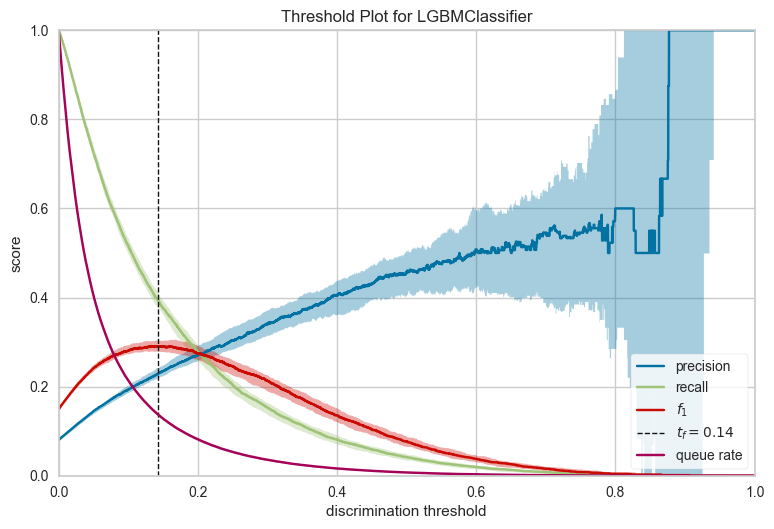

YellowbrickAttributeError: neither visualizer 'DiscriminationThreshold' nor wrapped estimator 'LGBMClassifier' have attribute 'force_model'

YellowbrickAttributeError: neither visualizer 'DiscriminationThreshold' nor wrapped estimator 'LGBMClassifier' have attribute 'force_model'

YellowbrickAttributeError: neither visualizer 'DiscriminationThreshold' nor wrapped estimator 'LGBMClassifier' have attribute 'force_model'

In [165]:
## Threshold
from yellowbrick.classifier.threshold import discrimination_threshold
discrimination_threshold(lgbm_model, X_train_transformed, y_train)


2023/09/11 02:29:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '28f794e952624c9882ca0ed35d14e094', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/09/11 02:33:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '26ee872e31dc4e9e98dff063fe62648b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/09/11 02:37:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0319d9b220354c7d96e7b4279d4681e3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/09/11 02:41:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7310f9a5afe3487d97768c8bbf143911', which will track hyperparameters, performance metrics, model artifacts, and lineage i

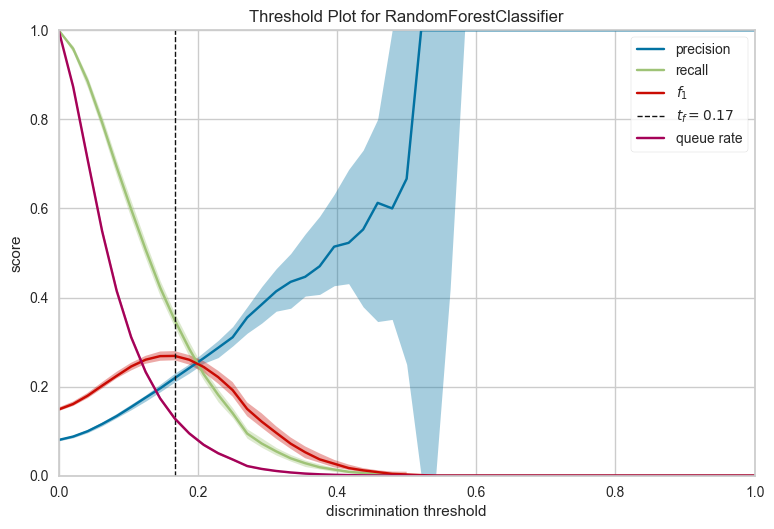

<Axes: title={'center': 'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [166]:
from yellowbrick.classifier import DiscriminationThreshold

# Créez votre modèle RandomForestClassifier
model = RandomForestClassifier()

# Créez une instance de la visualisation DiscriminationThreshold
visualizer = DiscriminationThreshold(model)

# Adapter le modèle et générer la visualisation
visualizer.fit(X_train, y_train)
visualizer.show()

In [167]:
#from yellowbrick.classifier import DiscriminationThreshold

# Créez votre modèle RandomForestClassifier
#model = RandomForestClassifier()

# Créez une instance de la visualisation DiscriminationThreshold
#visualizer = DiscriminationThreshold(model)

# Adapter le modèle et générer la visualisation
#visualizer.fit(X_train_transformed, y_train)
#visualizer.show()

### Matrice de confusion

La matrice de confusion permet d'évaluer l'exactitude d'une classification.

Les individus dont la valeur cible réelle est 0 et dont la prédiction est 0 sont les 'True Negatives' dits aussi 'TN'

Les individus dont la valeur cible réelle est 0 alors que la prédiction est 1 sont les 'False Negatives' appelés aussi 'FN'

Les individus dont la valeur cible réelle est 1 alors que la prédiction est 0 sont les 'False Positives' appelés aussi 'FP'

Les individus dont la valeur cible réelle est 1 et dont la prédiction est 1 sont les 'True Positives' appelés aussi 'TP'

In [168]:
def matrix_confusion (X,y):
    cm = confusion_matrix(X, y)
    print('\nTrue Positives(TP) = ', cm[0,0])
    print('\nTrue Negatives(TN) = ', cm[1,1])
    print('\nFalse Positives(FP) = ', cm[0,1])
    print('\nFalse Negatives(FN) = ', cm[1,0])
    return  cm

In [169]:
# visualize confusion matrix with seaborn heatmap
def plot_matrx_confusion (data):
    cm_matrix = pd.DataFrame(data, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                     index=['Predict Positive:1', 'Predict Negative:0'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

**Matrice de confusion de random Forest**


True Positives(TP) =  37535

True Negatives(TN) =  38484

False Positives(FP) =  7564

False Negatives(FN) =  6750


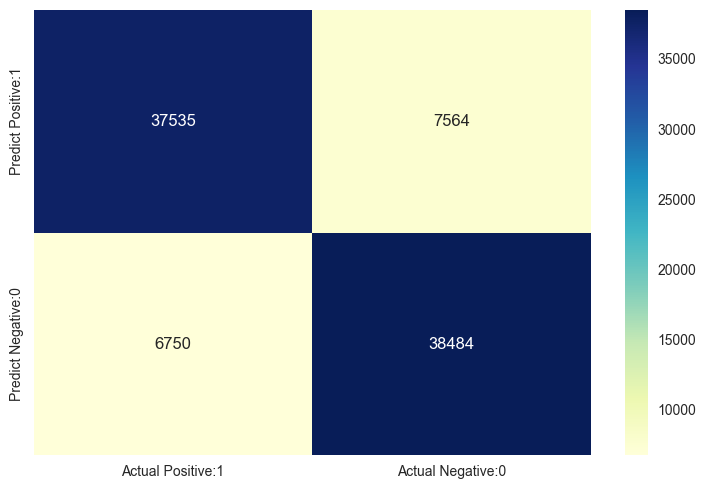

In [170]:
plot_matrx_confusion (matrix_confusion(y_test_smtomek,y_predicted_rf))

In [222]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_metrics(y_true, y_pred):
    # Calculer les métriques en utilisant les fonctions de scikit-learn
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    # Créer un DataFrame avec les résultats
    results = pd.DataFrame({
        'Métrique': ['Précision (Precision)', 'Rappel (Recall)', 'F-score (F1-score)', 'Exactitude (Accuracy)'],
        'Valeur': [precision, recall, f1, accuracy]
    })

    return results

results_df = calculate_metrics(y_test_smtomek,y_predicted_rf)
print(results_df)


                Métrique    Valeur
0  Précision (Precision)  0.835737
1        Rappel (Recall)  0.850776
2     F-score (F1-score)  0.843189
3  Exactitude (Accuracy)  0.841542


**Matrice de confusion de LightGBM**


True Positives(TP) =  44784

True Negatives(TN) =  41452

False Positives(FP) =  315

False Negatives(FN) =  3782


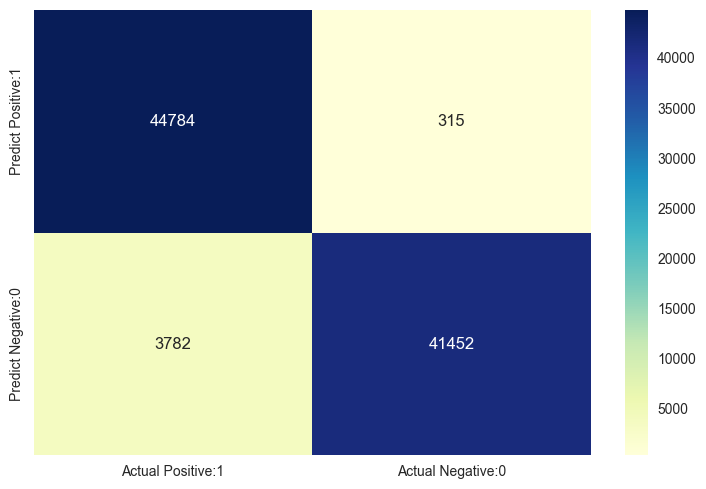

In [171]:
plot_matrx_confusion (matrix_confusion(y_test_smtomek,y_predicted_lgbm))

In [223]:
results_df = calculate_metrics(y_test_smtomek,y_predicted_lgbm)
print(results_df)

                Métrique    Valeur
0  Précision (Precision)  0.992458
1        Rappel (Recall)  0.916390
2     F-score (F1-score)  0.952909
3  Exactitude (Accuracy)  0.954646


**Matrice de confusion de AdaBoost**

In [172]:
#plot_matrx_confusion (matrix_confusion(y_test_smtomek,y_predicted_ada))

**Matrice de confusion Logistic Regression**

In [173]:
#plot_matrx_confusion (matrix_confusion(y_test_smtomek,y_predicted_logreg))

**Matrice de confusion XGBoost**

In [174]:
#plot_matrx_confusion (matrix_confusion(y_test_smtomek,y_predicted_xgb))

**Matrice de confusion Gaussian Naive Bayes**

In [175]:
#plot_matrx_confusion (matrix_confusion(y_test_smtomek,y_predicted_nb))

La matrice de confusion résume le nombre de prédictions faites par chaque modèle pour chaque classe, et les classes auxquelles ces prédictions appartiennent réellement.

* Pour le random Forest : 84 % des prédictions positives sont vraies et 83 % des prédictions négatives sont vraies.
* Pour le Lightgbm : 91 % des prédictions positives sont vraies et 99 % des prédictions négatives sont vraies.

### Roc curve
le Roc curve résume les performances d'un classificateur sur tous les seuils possibles. Il est généré en traçant le taux de vrais positifs (axe des y) par rapport au taux de faux positifs (axe des x).

In [176]:
import scikitplot as skplt
from sklearn.metrics import roc_curve

**Roc curve pour Random Forest**

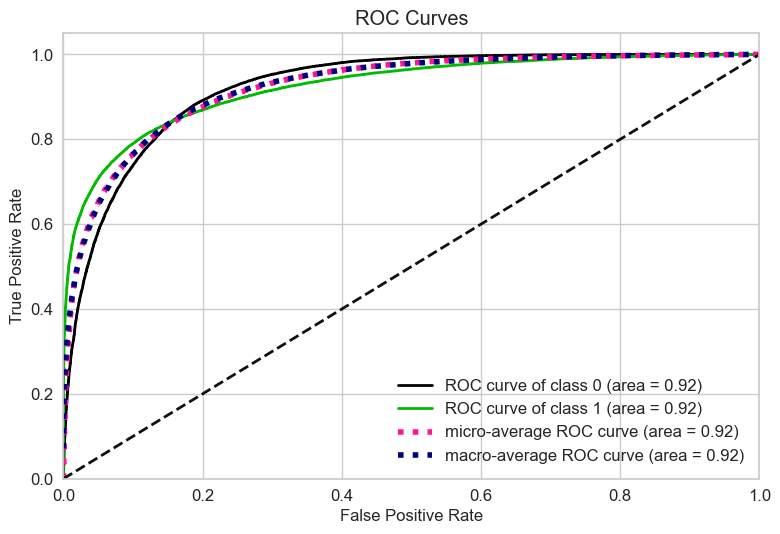

In [177]:
skplt.metrics.plot_roc_curve(y_test_smtomek, y_probability_rf)
plt.show()

**Roc curve pourLightgbm**

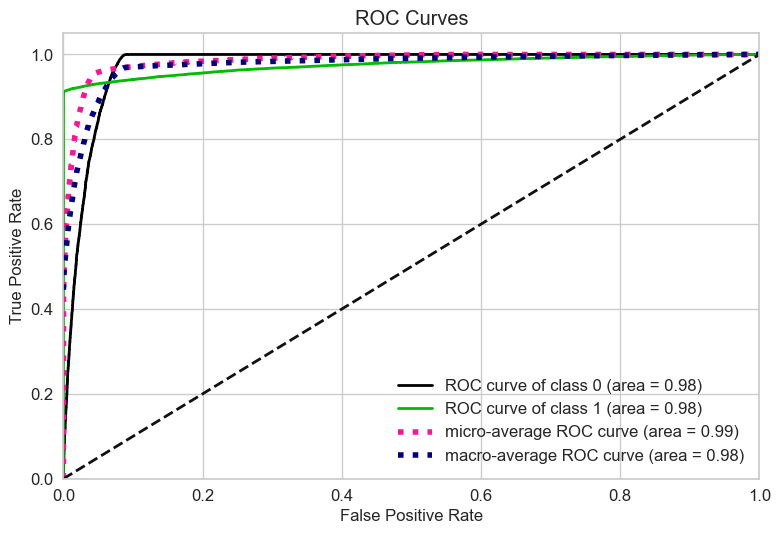

In [178]:
skplt.metrics.plot_roc_curve(y_test_smtomek, y_probability_lgbm)
plt.show()

### metrique bancaire
La métrique Bancaire consiste à calculer le gain obtenu pour l'ensemble des individus du jeu de données. Pour cela, on va pénaliser le défaut (avec un gros poids correspondant aux potentiel pertes en capital) et bonifier un remboursement (faible poids correspondant aux intérêts générés). Les valeurs des poids sont les suivantes :

fn_value = -10 tp_value = 0 tn_value = 1 fp_value = -0.5

In [179]:
def bank_score(y_true, y_pred):
    fn_value=-10     # unexpected default (real: default(P), predicted: not-default(N))
    fp_value=-0.5    # unexpected not-default (real: not-default, predicted: default)
    tp_value=0       # expected default
    tn_value=1
    
    # Matrice de Confusion
    (tp, fp, fn, tn) = confusion_matrix(y_true,y_pred).ravel()
    
    # Full negative and positive cases
    N = tn + fp # total true not-default
    P = tp + fn # total true default
    
    Gain_tot = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    G_max = (fp + tn)*tn_value + (fn + tp)*tp_value
    G_min = (fp + tn)*fp_value + (fn + tp)*fn_value
    
    G_normalized = (Gain_tot - G_min)/(G_max - G_min)
    
    return G_normalized 

In [180]:
bank_score(y_test_smtomek, y_predicted_rf)


0.8459804423330116

In [181]:
bank_score(y_test_smtomek, y_predicted_lgbm)

0.930162745378759

In [182]:
bank_scorer=make_scorer(bank_score, fn_value=-10, fp_value=-0.5, tp_value=0, tn_value=1, greater_is_better=True)

### FBeta score
La mesure Fbeta est une métrique à score unique configurable pour évaluer un modèle de classification binaire basé sur les prédictions faites pour la classe positive.

Elle est calculée en utilisant la précision et le rappel.

La précision est une métrique qui calcule le pourcentage de prédictions correctes pour la classe positive. Le Recall calcule le pourcentage de prédictions correctes pour la classe positive parmi toutes les prédictions positives qui pourraient être faites. Maximiser la précision minimisera les erreurs de faux positifs, tandis que maximiser le rappel minimisera les erreurs de faux négatifs.

La mesure Fbeta est une généralisation de la mesure F qui ajoute un paramètre de configuration appelé bêta. Une valeur bêta par défaut est 1,0, ce qui est identique à la F-mesure. Une valeur bêta plus petite, telle que 0,5, donne plus de poids à la précision et moins au rappel, tandis qu'une valeur bêta plus élevée, telle que 2,0, donne moins de poids à la précision et plus de poids au rappel dans le calcul du score.

Dans notre cas, on s'interesse à maximiser le rappel donc minimiser les erreurs de faux négatifs.==> beta=2

In [183]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)

### Seuil solvabilité optimal
Ce problème de classification présente un déséquilibre de classe. Donc,le seuil par défaut peut entraîner de mauvaises performances. Pour améliorer les performances d'un modèle qui prédit les probabilités sur un problème de classification déséquilibré, on va régler le seuil utilisé pour mapper les probabilités aux étiquettes de classe.

In [184]:
def seuil_optimal_search(y_true,y_prob,score_function):
    thresholds = np.linspace(0.0, 1, 30)
    scores_thresholds = []
    
    for th in thresholds:
            y_pred = (y_prob[:,1]>th)*1
            scores_thresholds.append(score_function(y_true,y_pred))
    # Plot  
    plt.plot(thresholds, scores_thresholds)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice banquaire")
    plt.xticks(np.linspace(0.1, 1, 10))
    
    idx_best_th = scores_thresholds.index(max(scores_thresholds))
    return thresholds[idx_best_th]

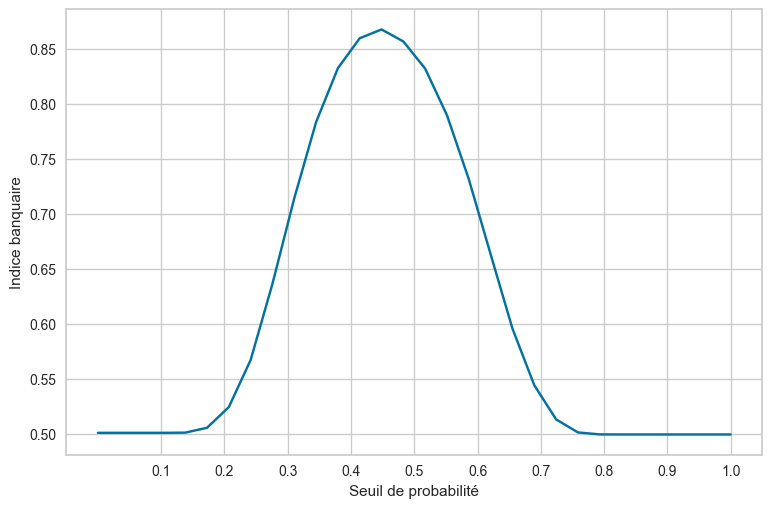

In [185]:
seuil_optim_rf =seuil_optimal_search(y_test_smtomek,y_probability_rf,bank_score)

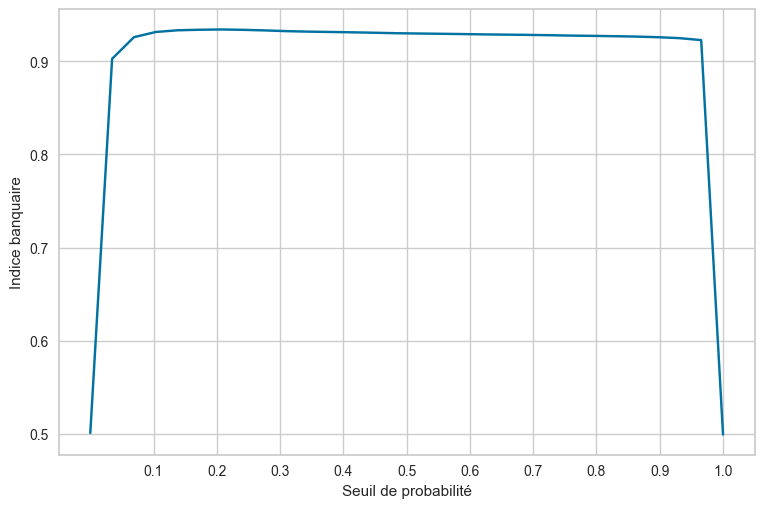

In [186]:
seuil_optim_lgbm =seuil_optimal_search(y_test_smtomek,y_probability_lgbm,bank_score)

In [187]:
seuil_optim_rf

0.4482758620689655

In [188]:
seuil_optim_lgbm

0.20689655172413793

In [189]:
y_pred_rf_th_optim = (y_probability_rf[:,1]>seuil_optim_rf)*1
y_pred_lgbm_th_optim = (y_probability_lgbm[:,1]>seuil_optim_lgbm)*1

* Le seuil optimal pour le modèle random Forest est : 
* Le seuil optimal pour le modèle Lightgbm est : 

## Evaluation modèle par rapport au seuil de solvabilité

Dans cette partie, on va évaluer les performances des deux modèles de classification optimisés et entrainés (RF et Lgbm) par rapport aux différentes métriques de scoring en utilisant le seuil de solvabilité optimal.

In [190]:
def eval_model(model,X,y,scoring):
    score = cross_val_score(model, X, y, scoring=scoring,cv=3)
    score_moy = score.mean()
    return score_moy

In [191]:
fbeta_score(y_test_smtomek,y_pred_rf_th_optim, beta=2)

0.8815065932357896

In [192]:
scoring_metrics = ['roc_auc',bank_scorer,ftwo_scorer]

In [193]:
rf_model_scores =[]
for metric in scoring_metrics:
    score = eval_model(rf_model,X_test_smtomek,y_test_smtomek,metric)
    rf_model_scores.append(score)
    print('score : ' ,score)

score :  0.9257316561153411
score :  nan
score :  0.851954038058547


In [194]:
rf_model_scores_thresh_optim =[]

rf_model_scores_thresh_optim.append(roc_auc_score(y_test_smtomek,y_pred_rf_th_optim))
rf_model_scores_thresh_optim.append(bank_score(y_test_smtomek,y_pred_rf_th_optim))
rf_model_scores_thresh_optim.append(fbeta_score(y_test_smtomek,y_pred_rf_th_optim,beta=2))

In [195]:
lgbm_model_scores =[]
for metric in scoring_metrics:
    score = eval_model(lgbm_model,X_test_smtomek,y_test_smtomek,metric)
    lgbm_model_scores.append(score)
    print('score : ' ,score)

score :  0.9745356916380109
score :  nan
score :  0.9306639513258013


In [196]:
lgbm_model_scores_thresh_optim =[]

lgbm_model_scores_thresh_optim.append(roc_auc_score(y_test_smtomek,y_pred_lgbm_th_optim))
lgbm_model_scores_thresh_optim.append(bank_score(y_test_smtomek,y_pred_lgbm_th_optim))
lgbm_model_scores_thresh_optim.append(fbeta_score(y_test_smtomek,y_pred_lgbm_th_optim,beta=2))

In [197]:
df_scores= pd.DataFrame( {'metrics': ['roc_auc','bank_score','f_beta']})

In [198]:
df_scores['rf_scores']=rf_model_scores

In [199]:
df_scores['lgbm_scores']=lgbm_model_scores

In [200]:
df_scores['rf_scores_thresh_optim']=rf_model_scores_thresh_optim

In [201]:
df_scores['lgbm_scores_thresh_optim']=lgbm_model_scores_thresh_optim

In [202]:
df_scores

,metrics,rf_scores,lgbm_scores,rf_scores_thresh_optim,lgbm_scores_thresh_optim
0,roc_auc,0.925732,0.974536,0.796013,0.938515
1,bank_score,NaN,NaN,0.867489,0.934289
2,f_beta,0.851954,0.930664,0.881507,0.934562


In [203]:
df = pd.melt(df_scores, id_vars="metrics", var_name="model", value_name="scores")

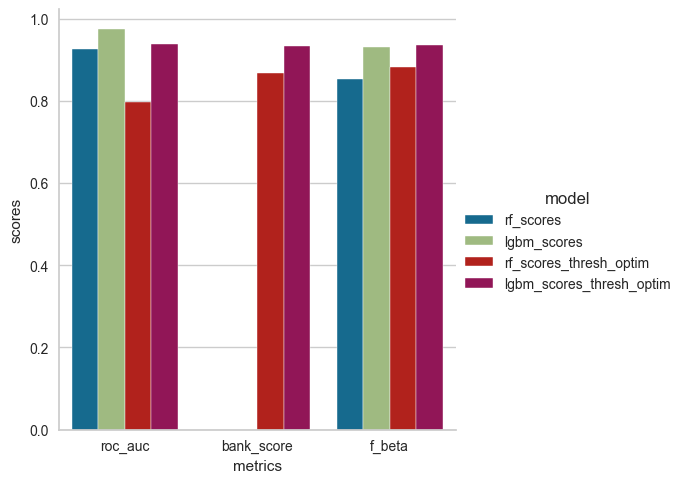

In [204]:
sns.catplot(x='metrics', y='scores', hue='model', data=df, kind='bar')

Conclusion :
En comparant les performances de deux modèles de classification, on trouve que le Lightgbm est plus performant suivants les différents scores comme la métrique bancaire, le roc et la fbeta.

Les modèles de boosting (lgbm) sont plus sujets au surentrainement. Ils offrent une précision beaucoup plus élevée et sont plus comptabiles avec les grands ensembles de données .

On remarque que le seuil de solvabilité permet d'ajuster les scores de roc et fbeta pour les deux modèles. Contrairement au score bancaire qui augmente pour les deux modèles en appliquant ce seuil de solvabilité.

## Feature importance

In [205]:
import shap

In [206]:
def important_feature_df (classifier, X) :
    X_importance = X
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_importance)
    vals= np.abs(shap_values).mean(0)
    x = pd.DataFrame(X)
    feature_importance = pd.DataFrame(list(zip(x.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    return feature_importance

In [207]:
def feature_importance_graphic(classifier, X):
    X_importance = X
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_importance)
    shap.summary_plot(shap_values[1], X_importance)
    shap.summary_plot(shap_values, X_importance, plot_type='bar')
    #shap.force_plot(explainer.expected_value[1], shap_values[1], X)
    return 

In [211]:
!pip install shap

In [ ]:
!pip uninstall numpy

In [ ]:
!pip install numpy==1.23.1

In [213]:
#!!!!! debug
import numpy as np
np.bool = np.bool_

In [214]:
df_impor_feature=important_feature_df(rf_model, features_sample)

In [215]:
#!!!!! debug
df_impor_feature=important_feature_df(lgbm_model, features_sample)

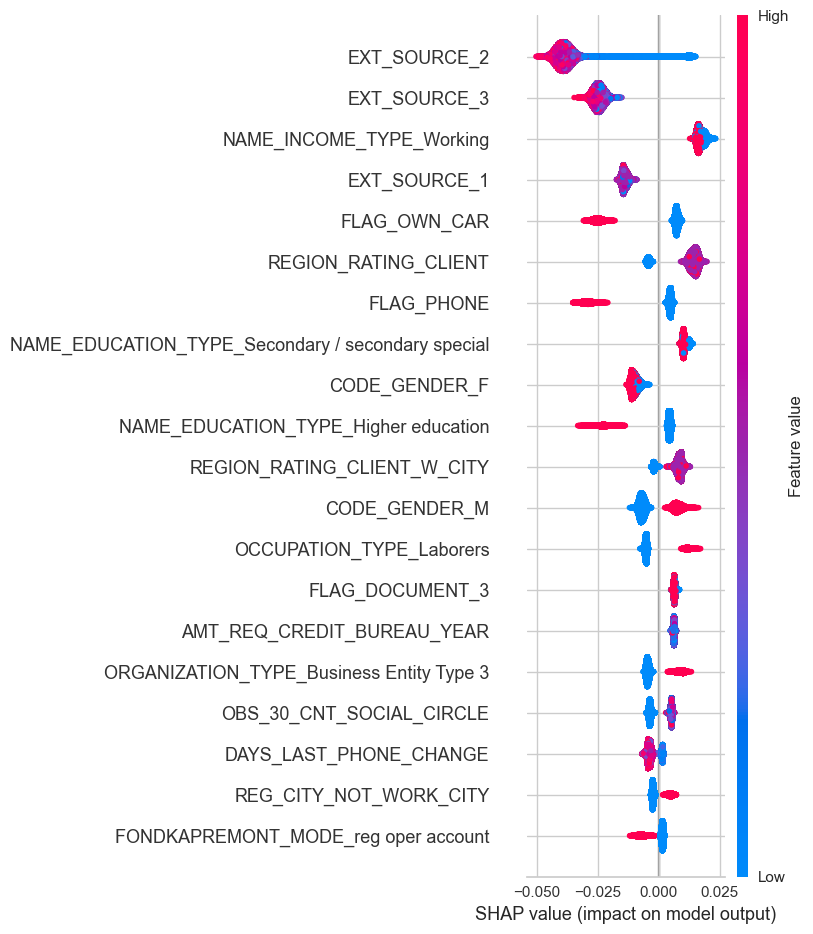

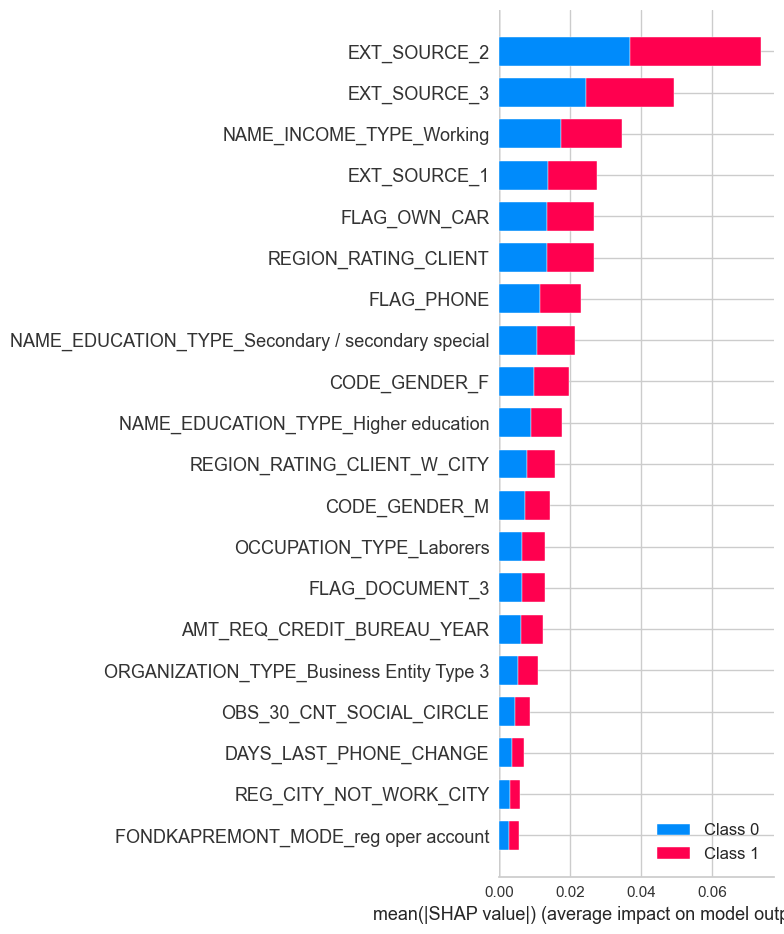

In [218]:
feature_importance_graphic(rf_model, pd.get_dummies(features_sample))

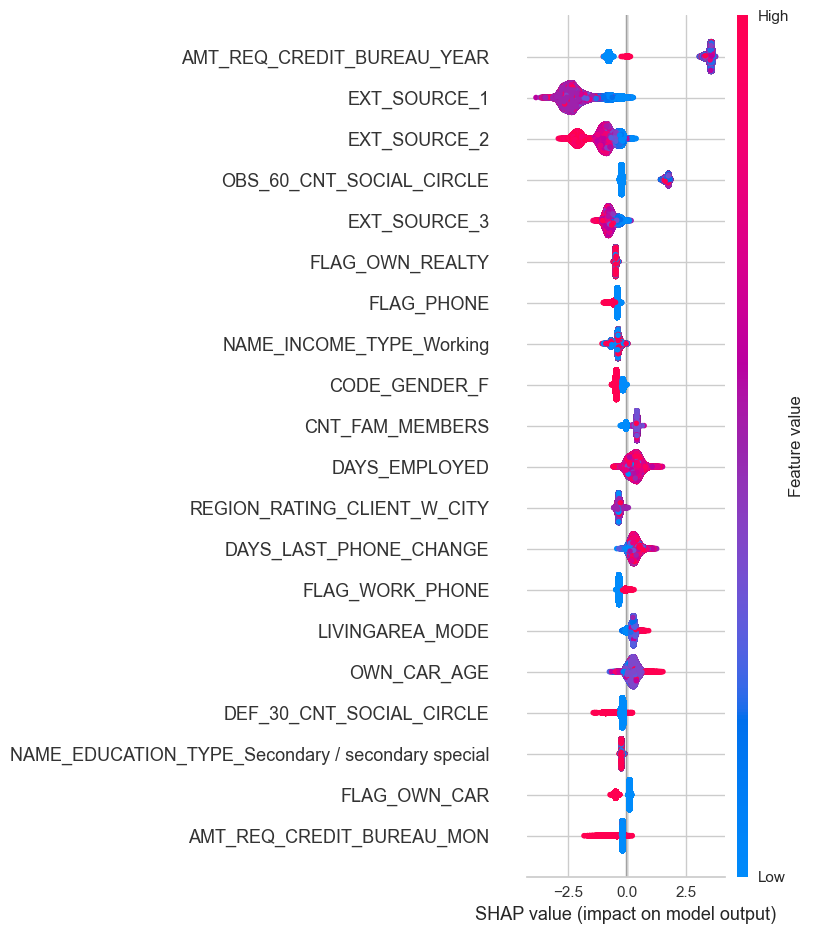

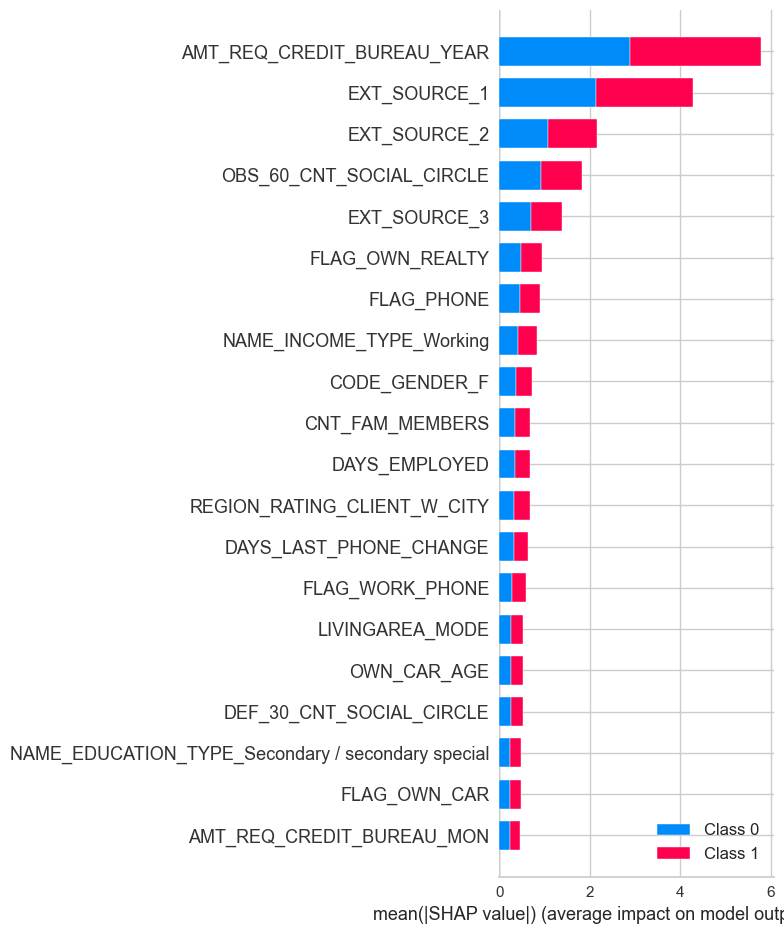

In [219]:
feature_importance_graphic(lgbm_model,pd.get_dummies(features_sample))

# Conclusion sur modeling

Nous avons choisi de travailler avec le modèle RandomForestClassifier parce que ces resultats sont extremment cohérents à ce qui a été fait sur kaggle. Il ya un doute sur l'overfitting de LGBMClassifier. 
Cependant, ce pc n'etant pas extremment rapide, il faudrait normalement entrainer le modèle sur ses 300 000 observations tel que définit plus haut. Cela permettrait d'améliorer encore plus les résultats.

Nous allons afficher tous les packages et bibliothèques qui ont été utilisées dans cet environnement afin de permettre une reproductivité triviale du code par toute personne qui souhaite le tester.

In [221]:
import pkg_resources

# Listez toutes les bibliothèques installées dans l'environnement Conda
installed_packages = pkg_resources.working_set

# Affichez le nom et la version de chaque bibliothèque
for package in installed_packages:
    print(f"{package.key}=={package.version}")


pynndescent==0.5.10
umap-learn==0.5.3
automat==20.2.0
btrees==4.11.3
babel==2.11.0
bottleneck==1.3.5
brotli==1.0.9
doublemetaphone==1.1
flask==2.3.2
flask-compress==1.13
flask-cors==3.0.10
gitpython==3.1.32
heapdict==1.0.1
imagehash==4.3.1
jinja2==3.1.2
keras-preprocessing==1.1.2
mako==1.2.4
markdown==3.4.1
markupsafe==2.1.1
metaphone==0.6
pillow==10.0.0
protego==0.1.16
pydispatcher==2.0.5
pyjwt==2.4.0
pylbfgs==0.2.0.14
pynacl==1.5.0
pyqt5==5.15.7
pyqt5-sip==12.11.0
pyqtwebengine==5.15.4
pysocks==1.7.1
pywavelets==1.4.1
pyyaml==6.0
pygments==2.15.1
pympler==1.0.1
qdarkstyle==3.0.2
qtawesome==1.2.2
qtpy==2.2.0
rtree==1.0.1
sqlalchemy==1.4.39
scrapy==2.8.0
send2trash==1.8.0
sphinx==5.0.2
tbb==0.2
twisted==22.10.0
unidecode==1.2.0
absl-py==1.4.0
affinegap==1.12
aiobotocore==2.5.0
aiofiles==22.1.0
aiohttp==3.8.3
aioitertools==0.7.1
aiosignal==1.2.0
aiosqlite==0.18.0
alabaster==0.7.12
alembic==1.11.1
altair==5.0.1
anaconda-client==1.12.0
anaconda-navigator==2.3.2
anyio==3.5.0
appdirs==1.4.4